# Школа глубокого обучения ФПМИ МФТИ
# Домашнее задание. Весна 2021
# Сегментация изображений

Задание выполнила Астафьева Светлана (телеграм @sastafyeva)

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 20 баллов. 

Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга?

# Импорт библиотек

In [1]:
import os

from skimage.io import imread
from skimage.transform import resize
import pickle

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader

from time import time
from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

Ниже список версий всех библиотек, использованных при создании этого ноутбука,был выгружен в файл requirements.txt, который приложен к работе

In [2]:
!pip freeze > requirements.txt 

In [2]:
torch.cuda.empty_cache()
!nvidia-smi

Sun May 16 16:06:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Для обеспечения воспроизводимости напишем 2 функции.

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id): # передается в параметр DataLoader(...worker_init_fn=seed_worker)
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
set_seed(2147483647)

In [5]:
DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


# Загрузка данных

## Скачивание и сохранение на Google-disk

[ADDI project](https://www.fc.up.pt/addi/ph2%20database.html)
Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы будем их **сегментировать**.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
DATA_DIR = '/content/gdrive/MyDrive/DLS_MFTI/DLS_adv/7W_semantic_segmentation/homework/'

Скачать архив нужно один раз к себе на диск (текущая ссылка не соответствует ссылке в бейзлайне, т.к. она оказалась неактивна на момент скачивания). Повторное скачивание не требуется. Путь для сохранения файла нужно указать свой.

In [ ]:
!wget -b -P /content/gdrive/MyDrive/DLS_MFTI/DLS_adv/7W_semantic_segmentation/homework/ https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

Continuing in background, pid 334.
Output will be written to ‘wget-log.1’.


## Распаковка архива, преобразование типа данных

Разархивируем файл. Каждый раз при перезапуске ноутбука нужно проводить разархивацию (файлы сохраняются во временную папку). Путь с доступом к архиву нужно указать свой.

In [8]:
get_ipython().system_raw("unrar x /content/gdrive/MyDrive/DLS_MFTI/DLS_adv/7W_semantic_segmentation/homework/PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Загрузим датасет с помощью [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [9]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.

In [10]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [11]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Загружено {len(X)} изображений')

Загружено 200 изображений


Чтобы убедиться, что все корректно, отрисуем несколько изображений



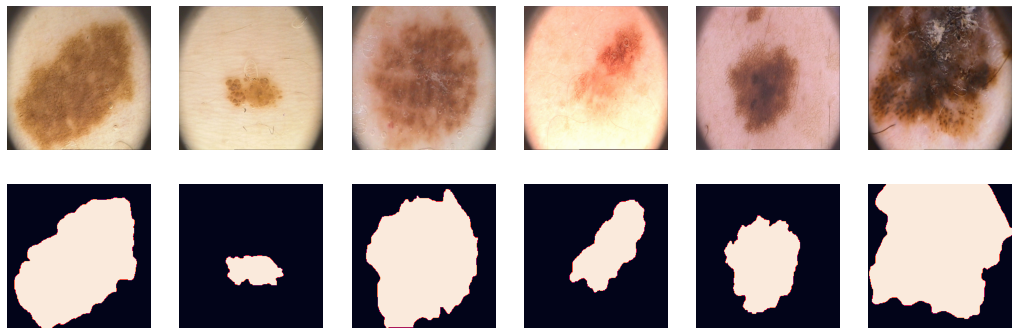

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i+6])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i+6])
plt.show();

Разделим наши 200 картинок на 100/50/50 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), replace=False)
tr, val, ts = np.split(ix, [100, 150])
print(len(tr), len(val), len(ts))

100 50 50


Запишем индексы в файл, чтобы в дальнейшем при обучении всех сетей использовать одни и те же индексы для каждой выборки.

In [ ]:
dict_ind = {i: j for i, j in zip(['tr', 'val', 'ts'],[tr, val, ts])}

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'wb') as f:
  pickle.dump(dict_ind, f)

# Реализация различных архитектур

Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

# SegNet [2 балла]

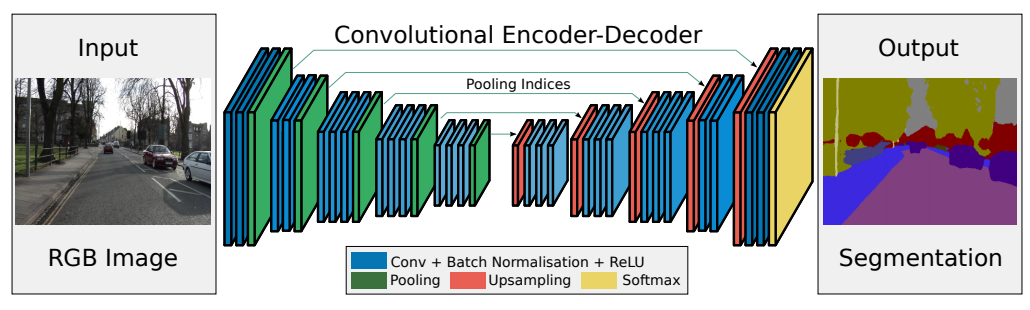

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Архитектрура SegNet основана на VGG-16 без полносвязных слоев. Каждый слой декодера зеркально повторяет слой кодировщика, но выполняет операции в обратном порядке. Это полностью сверточная сеть (FCN).

Чтобы воспроизвести архитектуру, загрузим VGG-16 и посмотрим, какие у нее слои

In [ ]:
vgg = models.vgg16()
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

В оригинальной VGG-16 нет слоев BatchNorm, однако на схеме сети они есть. Добавим их в архитектуру. Функция активации та же.

Encoder:

Convolution:
- kernel_size одинаковый. Укажем = 3.
- stride = 1 по умолчанию.
- padding одинаковый. Укажем 1.

Pool:
- kernel_size. Укажем = 2.
- stride = kernel_size по умолчанию.
- padding не требуется.
- return_indices нужно указать True, чтобы передавать в слои Unpool.


Decoder:\
Нужно сделать зеркально почти тоже самое.

Convolution:
- kernel_size одинаковый. Укажем = 3.
- stride = 1 по умолчанию.
- padding одинаковый. Укажем = 1.
- у нас бинарная классификация, последний слой будет с 1 выходным каналом без активации.
 

Unpool:
- kernel_size. Укажем = 2.
- stride = kernel_size по умолчанию.
- padding не требуется.
- Нужно передать индексы максимальных элементов.

**UPD** \
Я использовала вариант ***SegNet-Basic***, где используется 4 энкодера и 4 декодера (чтобы уменьшить количество параметров сети). Но добавила bottleneck между энкодером и декодером (в процессе экспериментов над архитектурой сети мне показалось, что у такого варианта выше качество предсказаний, но результаты экспериментов не сохранились, поэтому я не могу с уверенностью утверждать, что этот вариант лучше, чем предложенный авторами статьи).

In [12]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        # pool и unpool везде имеют одинаковые параметры, не будем дублировать
        self.pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2)

        self.enc_conv0 = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # self.pool0 =   # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )        
        # self.pool1 =  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )  
        # self.pool2 =  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # self.pool3 =  # 32 -> 16

        # bottleneck
        self.bottleneck = nn.Sequential(
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        

        # decoder (upsampling)
        # self.upsample0 =  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        # self.upsample1 =  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # self.upsample2 =   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # self.upsample3 =   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)            
        )

    def forward(self, x):
        # encoder
        e0, indices0 = self.pool(self.enc_conv0(x))
        e1, indices1 = self.pool(self.enc_conv1(e0))
        e2, indices2 = self.pool(self.enc_conv2(e1))
        e3, indices3 = self.pool(self.enc_conv3(e2))

        # bottleneck
        b0 = self.bottleneck(e3)


        # decoder     
        d0 = self.dec_conv0(self.unpool(b0, indices3))
        d1 = self.dec_conv1(self.unpool(d0, indices2))
        d2 = self.dec_conv2(self.unpool(d1, indices1))
        d3 = self.dec_conv3(self.unpool(d2, indices0))  # no activation
        
        
        return d3

In [ ]:
import torchsummary

Segnet_bce = SegNet().to(DEVICE)

torchsummary.summary(Segnet_bce, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Слегка поменяем предложенную метрику, сделаем усреднение по батчу и вернем число, а не тензор.

In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    
    outputs = outputs.view(-1).byte()  
    labels = labels.view(-1).byte()
    SMOOTH = 1e-7
    intersection = (outputs & labels).float().sum()  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum()         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
        
    return iou.mean().item()

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

**UPD**\
В процессе обучения я столкнулась с тем, что при некоторых больших значениях $\hat y$ функция $\exp(-\hat y)$ "улетает" в бесконечность, и весь $loss$ тоже. Для обеспечения численной стабильности я реализовала функцию так, как это предложено в [упрощении](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits).

In [14]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    
    loss = torch.clamp(y_pred, min=0) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    return loss.mean()

In [ ]:
# Проверим, что все корректно работает
# Создадим вектор из нулей и единиц
t1 = (torch.randn(25, 1, 256, 256) > 0).type(torch.float)
# Заменим 0 на -50, а 1 на +50
t2 = (t1.clone()-0.5)*100

# Создадим случайный вектор логитов
t3 = torch.randn(25, 1, 256, 256)

# Обе функции должны показать ноль
print(nn.BCEWithLogitsLoss()(t2, t1), bce_loss(t1, t2))
# Обе функции должны показать одинаковые значения
print(nn.BCEWithLogitsLoss()(t3, t1), bce_loss(t1, t3))

tensor(0.) tensor(0.)
tensor(0.8063) tensor(0.8063)


In [ ]:
# Проверим, корректно ли считается выбранная метрика. Она также равнять 1, т.к. у нас "полное совпадение" логитов и таргета
pred = t2 > 0
iou_pytorch(pred, t1)

1.0

# Тренировка [1 балл]

В процессе обучения будем сохранять статистику по каждой модели в таблицы. Сводную таблицу заведем сразу и сохраним на диск, чтобы после обучения ее только открывать и дописывать данные.\
В таблице будут содержаться следующие данные:
- loss_name. Названии функции потерь.
- num_params. Количество параментров модели.
- epochs. Количество эпох обучения.
- train_time. Общее время обучения модели.
- batch_size. Размер батча.
- best_epoch. Эпоха, на которой зафиксирована лучшее качество модели (по метрике на валидации). Сама модель сохранена и после завершения обучения возвращена функцией обучения.
- best_time. Время обучения до best_epoch (включительно).
- iou_val. Метрика на валидационном датасете, рассчитаная после завершения обучения модели на лучшей модели.
- iou_test. Метрика на тестовом датасете, рассчитаная после завершения обучения модели на лучшей модели.

In [ ]:
indexes = ['loss_name', 'num_params', 'epochs', 'train_time', 'batch_size', 'best_epoch', 'best_time', 'iou_val', 'iou_test']
df_pivot = pd.DataFrame(index=indexes)
df_pivot.to_csv(os.path.join(DATA_DIR, 'pivot_table_models.csv'))

Напишем отдельные функции для обучения и валидации (чтобы код был более читаемый)

In [16]:
def fit_epoch(model, train_loader, loss_fn, metric, optimizer):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    processed_size = 0
      
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(inputs)
        loss = loss_fn(labels, outputs)
                
        loss.backward()
        optimizer.step()
        preds = torch.sigmoid(outputs.detach().cpu()) > 0.5
                
        running_loss += loss.item() * inputs.size(0)
        running_iou += iou_pytorch(preds, labels.cpu()) * inputs.size(0)
        
        processed_size += inputs.size(0)
                
        optimizer.zero_grad()
              
    train_loss = running_loss / processed_size
    train_iou = running_iou / processed_size
    
    return train_loss, train_iou

In [17]:
def eval_epoch(model, val_loader, loss_fn, metric):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
       
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = loss_fn(labels, outputs)
            
            preds = torch.sigmoid(outputs.cpu()) > 0.5

        running_loss += loss.item() * inputs.size(0)
        running_iou += iou_pytorch(preds, labels.cpu()) * inputs.size(0)
        processed_size += inputs.size(0)
        
    val_loss = running_loss / processed_size
    val_iou = running_iou / processed_size

    return val_loss, val_iou

Обучение всех моделей будем проводить на 100 эпохах.\
**UPD**\
Я пробовала устанавливать условие сходимости по изменению функции потерь по этой формуле. $$ \frac {previousLoss - currentLoss}{currentLoss} < 0.001 $$
Но для некоторых функций потерь данное условие наступает раньше, чем модель достигает своего лучшего качества. Поэтому, я убрала это условие и обучила все модели на 100 эпохах. Для примера я оставила результат по UNet, обученной с условием остановки по сходимости.

In [19]:
def train_model(train_loader, val_loader, model, model_name, num_params, batch_size, epochs, loss_fn, metric, optimizer):
    X_val, Y_val = next(iter(data_val))
    
    since = time()

    # tol = 1e-3
    # stop_it = False
    # prev_loss = 1e5
    best_iou = 0


    dict_metrics = {
        'train_loss': [],
        'train_iou': [],
        'val_loss': [],
        'val_iou': []
    }

    log_template = "\nEpoch {ep:03d}  train_loss: {t_loss:0.4f} \
     val_loss {v_loss:0.4f}  train_iou {t_iou:0.4f}  val_iou {v_iou:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            set_seed(2147483647 + epoch)
            
            # train and val
            t_loss, t_iou = fit_epoch(model, train_loader, loss_fn, metric, optimizer)                    
            v_loss, v_iou = eval_epoch(model, val_loader, loss_fn, metric)

            # save history for graphs
            dict_metrics['train_loss'].append(t_loss)
            dict_metrics['train_iou'].append(t_iou)
            dict_metrics['val_loss'].append(v_loss)
            dict_metrics['val_iou'].append(v_iou)

            # save best model
            if v_iou > best_iou:
                best_iou = v_iou
                torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
                best_epoch = epoch + 1
                best_time = time() - since

            # save current model
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
            
                        
            # show intermediate results
            model.eval()  # testing mode
            outputs = model(X_val.to(DEVICE)).detach().cpu()            
            Y_hat = torch.sigmoid(outputs)

            # Visualize tools
            clear_output(wait=True)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=t_loss, v_loss=v_loss, t_iou=t_iou, v_iou=v_iou))

            
            plt.figure(figsize=(24, 8))
            for k in range(6):
                plt.subplot(3, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Input')
                plt.axis('off')

                plt.subplot(3, 6, k+7)
                plt.imshow(Y_val[k, 0].cpu(), cmap='gray')
                plt.title('Ground truth')
                plt.axis('off')

                plt.subplot(3, 6, k+13)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')            
            plt.show()

            
            # # check convergence
            # if abs((prev_loss - v_loss) / v_loss) < tol:
            #   time_elapsed = time() - since
            #   print('Training complete in {:.0f}m {:.0f}s. Convergence'.format(
            #         time_elapsed // 60, time_elapsed % 60))
            #   print('Best val iou: {:4f}'.format(best_iou))
            #   stop_it = True
            
            # prev_loss = v_loss

            # if stop_it:
            #   break

    # save metrics
    with open(os.path.join(DATA_DIR, model_name + '_loss_table.pickle'), 'wb') as f:
        pickle.dump(dict_metrics, f)
    
    # save pivot_table
    time_elapsed = time() - since
    df_pivot = pd.read_csv(os.path.join(DATA_DIR, 'pivot_table_models.csv'), index_col=0)
    df_pivot[model_name] = [loss_fn.__name__, 
                            num_params, epoch+1, 
                            round(time_elapsed), 
                            batch_size, best_epoch, 
                            round(best_time), 
                            0, 0
                            ]
    df_pivot.to_csv(os.path.join(DATA_DIR, 'pivot_table_models.csv'))
    # ['loss_name', 'num_params', 'epochs', 'train_time', 'batch_size', 'best_epoch', 'best_time', 'iou_val', 'iou_test']
            
              

    # загрузим лучшие веса модели
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))
    
    return model, dict_metrics

# Инференс [1 балл]

Функция $predict$ возвращет предсказание на одно поданное изображение в формате $numpy.array$.

In [15]:
def predict(model, input):
    # input - numpy.array shape (256, 256, 3)
    input = np.rollaxis(input[np.newaxis], 3, 1)
    X = torch.from_numpy(input).to(DEVICE)

    model.eval()  # testing mode
    with torch.set_grad_enabled(False):
      outputs = model(X).detach().cpu()
    
    pred =  (outputs.sigmoid() > 0.5).int().squeeze().numpy()
    # pred - numpy.array shape (256, 256)

    return pred

Функция для сохранения предсказаний моделей для одного одинакового изображения. Для итоговой визуальной оценки качества моделей. На вход функция принимает модель и название модели. 

In [16]:
def write_predict(model, model_name):
    try:
      with open(os.path.join(DATA_DIR, 'models_predictions.pickle'), 'rb') as f:
        predictions = pickle.load(f)
    except FileNotFoundError:
        predictions = dict()

    with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
          dict_index = pickle.load(f)
      
    input = X[dict_index['ts'][0]]
    one_predict = predict(model, input)

    predictions[model_name] = one_predict

    with open(os.path.join(DATA_DIR, 'models_predictions.pickle'), 'wb') as f:
         pickle.dump(predictions, f)

Функция для оценки качества модели. Принимает на вход модель, метрику и данные в виде Dataloader (с входными изображениями и масками, подаваемыми батчами).

In [22]:
def score_model(model, metric, data):
    # data = torch.utils.data.DataLoader
    
    model.eval()  # testing mode
    
    running_metric = 0.0
    processed_size = 0

    for inputs, labels in data:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            preds = torch.sigmoid(outputs.cpu()) > 0.5

        running_metric += metric(preds, labels.cpu()) * inputs.size(0)
        processed_size += inputs.size(0)
        
    metric = running_metric / processed_size

    return metric

Функция для записи метрик в сводную таблицу. Принимает на вход модель, имя модели в формате строки, Dataloaders, созданные для валидационного и тестового датасетов.

In [23]:
def edit_pivot(model, model_name, data_val, data_ts):

    iou_val = score_model(model, iou_pytorch, data_val)
    iou_test = score_model(model, iou_pytorch, data_ts)

    pivot_table = pd.read_csv(os.path.join(DATA_DIR, 'pivot_table_models.csv'), index_col=0)
    
    pivot_table.loc['iou_val', model_name] = round(iou_val, 4)
    pivot_table.loc['iou_test', model_name] = round(iou_test, 4)

    pivot_table.to_csv(os.path.join(DATA_DIR, 'pivot_table_models.csv'))

    return pivot_table

Функция для визуализации лоссов и метрик после обучения модели.
На вход функция принимает название модели и сама загружает сохраненный в процессе обучения словарь лоссов и метрик.

In [24]:
def visual_metrics_dict(model_name):
    with open(os.path.join(DATA_DIR, model_name + '_loss_table.pickle'), 'rb') as f:
        dict_metrics = pickle.load(f)
    
    plt.figure(figsize=(24, 9))
       
    plt.subplot(1,2,1)
    plt.plot(dict_metrics['train_loss'], label="t_loss")
    plt.plot(dict_metrics['val_loss'], label="v_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    
    plt.subplot(1,2,2)
    plt.plot(dict_metrics['train_iou'], label="t_iou")
    plt.plot(dict_metrics['val_iou'], label="v_iou")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("iou")
    
    plt.suptitle(model_name, fontsize=16)
    plt.show()

# Основной момент: обучение

# SegNet + bce_loss. 100 эпох.

In [ ]:
set_seed(2147483647)

Segnet_bce = SegNet().to(DEVICE)
model_name = 'SegNet_bce'
num_params = sum(p.numel() for p in Segnet_bce.parameters() if p.requires_grad)
max_epochs = 100

opt_Segnet_bce = optim.Adam(params = Segnet_bce.parameters(), lr=1e-3)

Создадим Dataloaders для загрузки данных

In [ ]:
batch_size = 25

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Thu May 13 20:40:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    41W / 250W |   1591MiB / 16280MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [12:31<00:00,  7.42s/it]


Epoch 100  train_loss: 0.0768      val_loss 0.2024  train_iou 0.9050  val_iou 0.8126


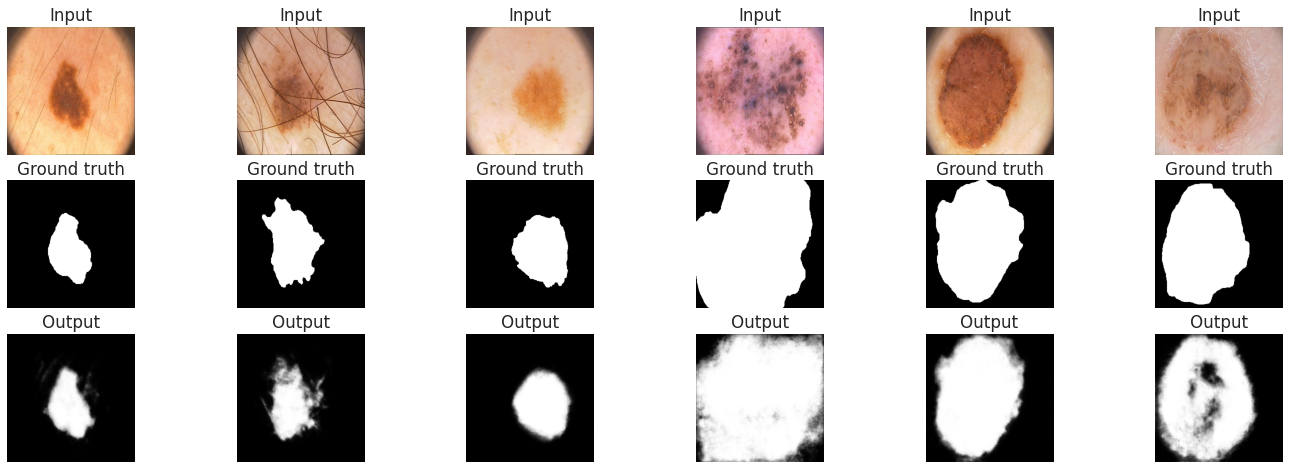

epoch: 100%|██████████| 100/100 [12:34<00:00,  7.54s/it]


In [ ]:
Segnet_bce, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Segnet_bce, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=bce_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Segnet_bce)

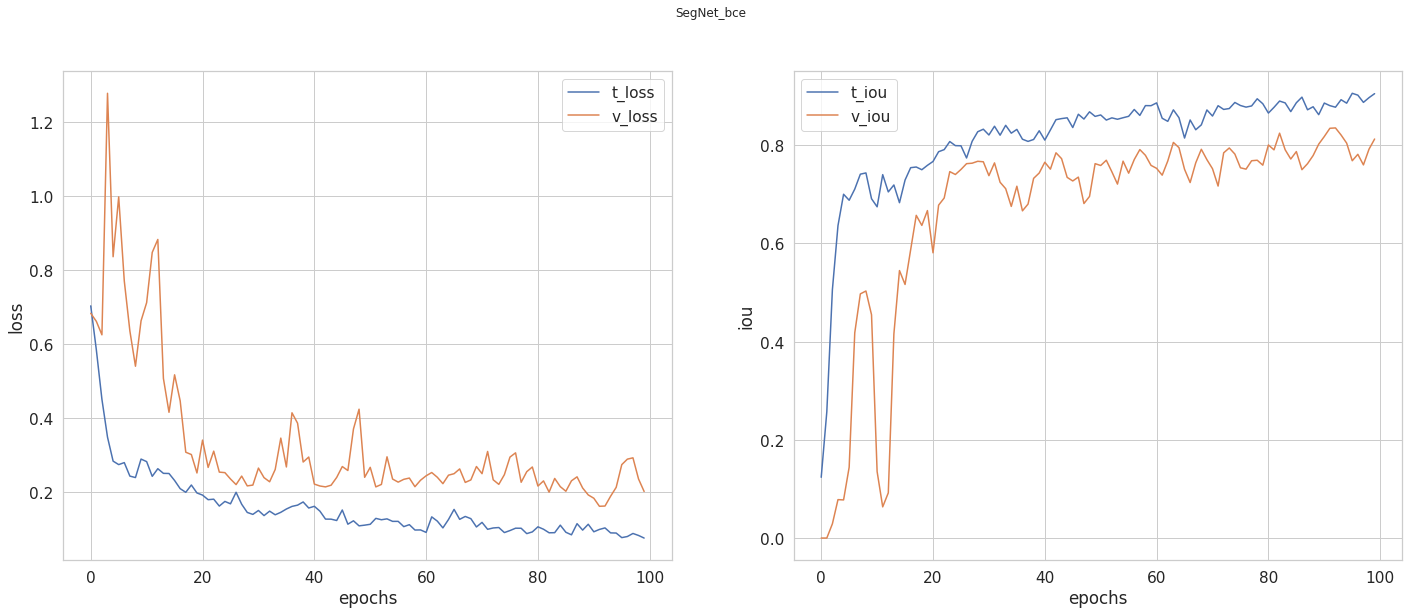

In [ ]:
# Визуализируем метрики
visual_metrics_dict('SegNet_bce')

In [ ]:
# Посмотрим сводную информацию о модели
edit_pivot(Segnet_bce, 'SegNet_bce', data_val, data_ts)

SegNet_bce
loss_name    bce_loss
num_params   22361089
epochs            100
train_time        754
batch_size         25
best_epoch         93
best_time         699
iou_val        0.8328
iou_test       0.8506

Функция потерь на валидации продолжает снижаться и на 100 эпохе. Сходимости не происходит. Но и переобучения не наблюдается (графики лоссов и метрик на обучающей и валидационной выборке "движутся" в унисон).

In [ ]:
# Запишем тестовое предсказание
write_predict(Segnet_bce, 'SegNet_bce')

# Дополнительные функции потерь [2 балла]

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [25]:
def dice_loss(y_real, y_logits, eps = 1e-7):
    y_pred =  torch.clamp(y_logits.sigmoid(), min=eps, max=1-eps).view(-1)
    y_real = y_real.view(-1)
    
    num = 2*(y_pred * y_real + eps).sum()
    den = (y_pred + y_real + eps).sum()
    res = 1 - (num / den)
    
    return res

In [ ]:
# Проверим, что все корректно работает
# Создадим вектор из нулей и единиц
t1 = (torch.randn(25, 1, 256, 256) > 0).type(torch.float)
# Заменим 0 на -50, а 1 на +50
t2 = (t1.clone()-0.5)*100

# Создадим случайный вектор логитов
t3 = torch.randn(25, 1, 256, 256)

# Обе функции потерь должны показать ноль
print(nn.BCEWithLogitsLoss()(t2, t1), dice_loss(t1, t2))

# Обе функции должны показать ненулевые значения
print(nn.BCEWithLogitsLoss()(t3, t1), dice_loss(t1, t3))

tensor(0.) tensor(0.)
tensor(0.8063) tensor(0.4999)


# SegNet + dice_loss. 100 эпох.

In [ ]:
set_seed(2147483647)

Segnet_dice = SegNet().to(DEVICE)
model_name = 'SegNet_dice'
num_params = sum(p.numel() for p in Segnet_dice.parameters() if p.requires_grad)
max_epochs = 100

opt_Segnet_dice = optim.Adam(params = Segnet_dice.parameters(), lr=1e-3)

In [ ]:
batch_size = 25

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sat May 15 11:39:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |    999MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [12:34<00:00,  7.43s/it]


Epoch 100  train_loss: 0.0624      val_loss 0.1287  train_iou 0.8838  val_iou 0.7740


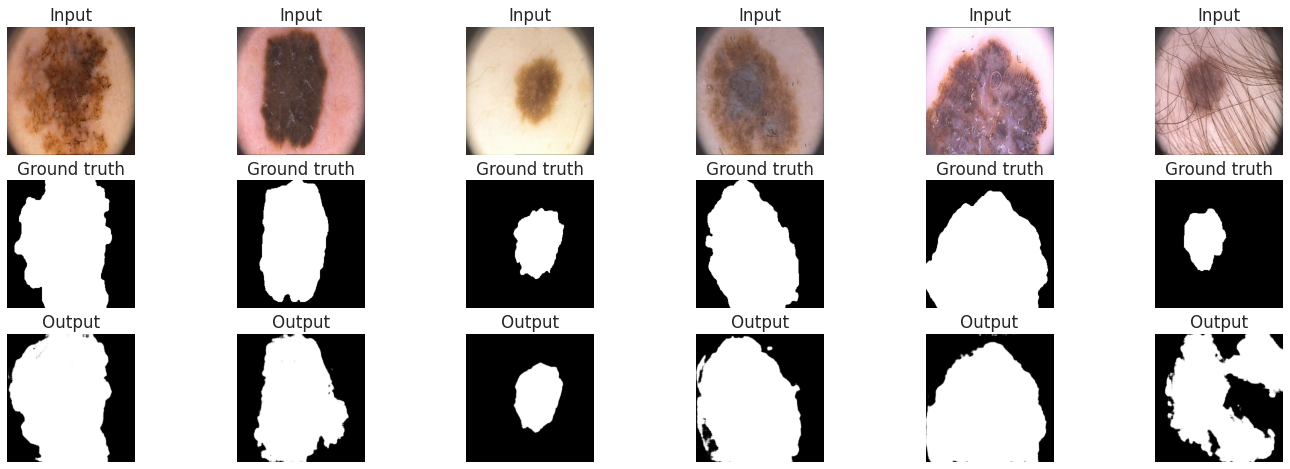

epoch: 100%|██████████| 100/100 [12:37<00:00,  7.57s/it]


In [ ]:
Segnet_dice, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Segnet_dice, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=dice_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Segnet_dice)

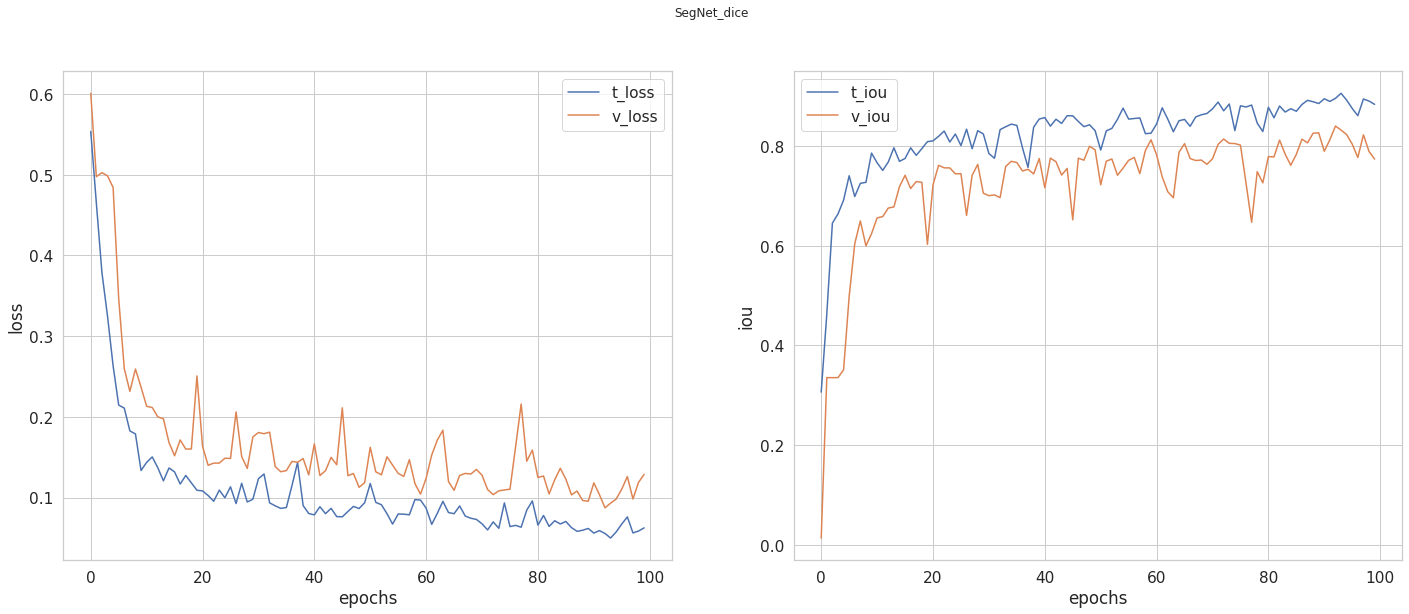

In [ ]:
# Визуализируем метрики
visual_metrics_dict('SegNet_dice')

In [ ]:
# Посмотрим сводную информацию о модели
edit_pivot(Segnet_dice, 'SegNet_dice', data_val, data_ts)

SegNet_bce SegNet_dice
loss_name    bce_loss   dice_loss
num_params   22361089    22361089
epochs            100         100
train_time        754         757
batch_size         25          25
best_epoch         93          93
best_time         699         702
iou_val        0.8328      0.8401
iou_test       0.8506      0.8199

Судя по графикам, модель не переобучается, можно пробовать продолжать обучение, но с меньшим learning rate. Качество модели на тестовой выборке ниже, чем у модели с функции потерь bce_loss, однако модель более уверена в предсказаниях. 

In [ ]:
# Запишем тестовое предсказание
write_predict(Segnet_dice, 'SegNet_dice')

# 2. Focal loss
[**Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [26]:
def focal_loss(y_real, y_logits, eps = 1e-7, gamma = 2):
    y_pred =  torch.clamp(y_logits.sigmoid(), min=eps, max=1-eps).view(-1)
    y_real = y_real.view(-1)
    
    fc_loss = -(1 - y_pred)**gamma * y_real * torch.log(y_pred) - (1 - y_real)*torch.log(1 - y_pred)
   
    return fc_loss.mean()

In [ ]:
# Проверим, что все корректно работает
# Создадим вектор из нулей и единиц
t1 = (torch.randn(25, 1, 256, 256) > 0).type(torch.float)
# Заменим 0 на -50, а 1 на +50
t2 = (t1.clone()-0.5)*100

# Создадим случайный вектор логитов
t3 = torch.randn(25, 1, 256, 256)

# Обе функции потерь должны показать ноль
print('Расчет функций потерь', nn.BCELoss()(torch.sigmoid(t2), t1), focal_loss(t1, t2))

# Обе функции должны показать ненулевые значения
print('Расчет функций потерь', nn.BCELoss()(torch.sigmoid(t3), t1), focal_loss(t1, t3))

Расчет функций потерь tensor(0.) tensor(5.9569e-08)
Расчет функций потерь tensor(0.8064) tensor(0.5764)


# SegNet + focal_loss. 100 эпох.

In [ ]:
set_seed(2147483647)

Segnet_focal = SegNet().to(DEVICE)
model_name = 'SegNet_focal'
num_params = sum(p.numel() for p in Segnet_focal.parameters() if p.requires_grad)
max_epochs = 100

opt_Segnet_focal = optim.Adam(params = Segnet_focal.parameters(), lr=1e-3)

In [ ]:
batch_size = 25

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Thu May 13 21:09:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    40W / 250W |   2119MiB / 16280MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [12:26<00:00,  7.41s/it]


Epoch 100  train_loss: 0.0628      val_loss 0.1538  train_iou 0.8649  val_iou 0.7784


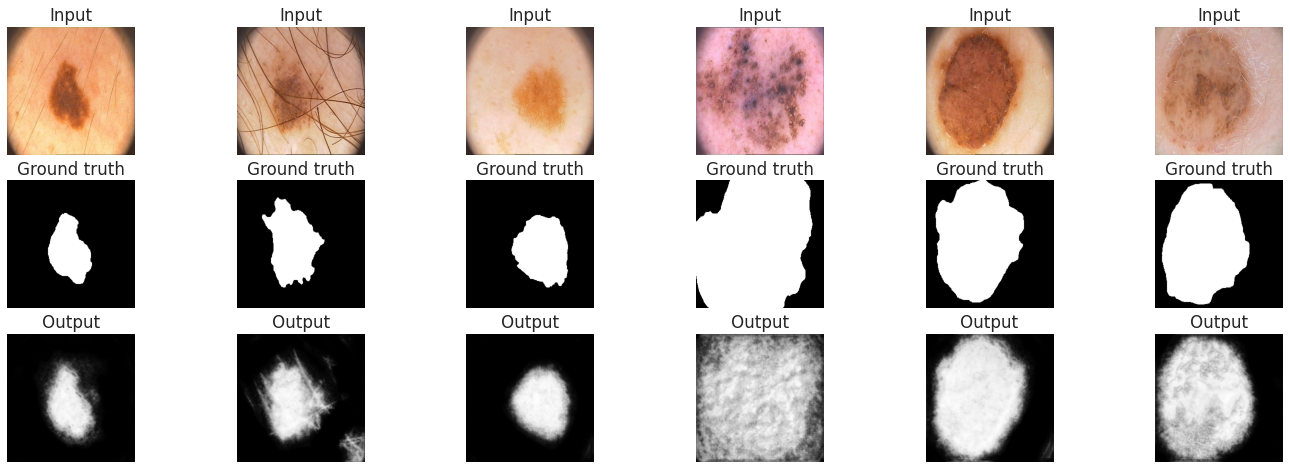

epoch: 100%|██████████| 100/100 [12:28<00:00,  7.48s/it]


In [ ]:
Segnet_focal, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Segnet_focal, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=focal_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Segnet_focal)

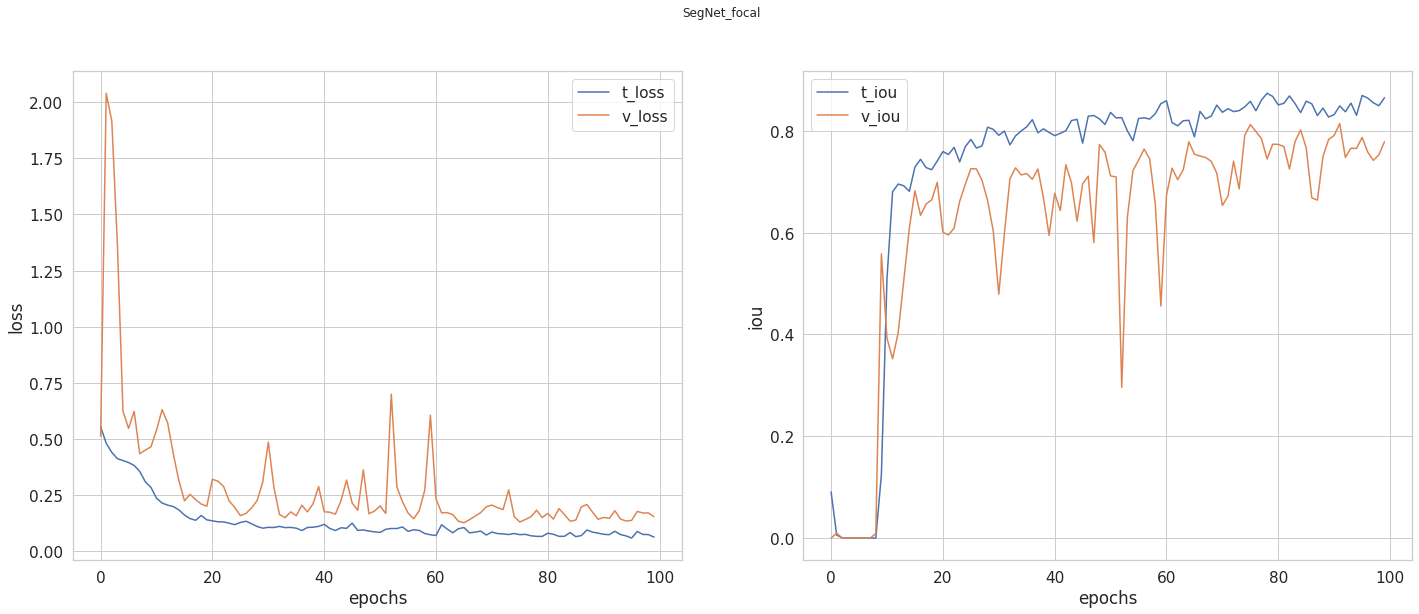

In [ ]:
# Визуализируем метрики
visual_metrics_dict('SegNet_focal')

In [ ]:
# Посмотрим сводную информацию о модели
edit_pivot(Segnet_focal, 'SegNet_focal', data_val, data_ts)

SegNet_bce SegNet_dice SegNet_focal
loss_name    bce_loss   dice_loss   focal_loss
num_params   22361089    22361089     22361089
epochs            100         100          100
train_time        754         757          748
batch_size         25          25           25
best_epoch         93          93           92
best_time         699         702          686
iou_val        0.8328      0.8401       0.8135
iou_test       0.8506      0.8199       0.8354

Модель не переобучается, судя по графикам. Но после 50 эпохи существенно loss не убывает, однако качество модели по метрике не стабильно. Кроме того, модель не уверена в предсказаниях, в отличие от dice_loss.

In [ ]:
# Запишем тестовое предсказание
write_predict(Segnet_focal, 'SegNet_focal')

----------------------------------------------------------------------------------------------

# [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

В качестве бонусной loss-функции я выбрала ***Combo loss***. Эта функция потерь является комбинацией dice-loss и модифицированной BCEloss. В своей реализации я опиралась на [работу](https://arxiv.org/pdf/1805.02798.pdf) и на [работу](https://www.researchgate.net/publication/342520628_A_survey_of_loss_functions_for_semantic_segmentation).

$$\mathcal L_{combo}(y, x) = \alpha \left (- \frac {1}{N}\sum_i \left[ \beta (y_i * \log(x_i)) + (1-\beta)(1-y_i)\log(1-x_i))\right] \right ) + (1-\alpha)\left(1 - \frac {2\sum_i x_iy_i}{\sum_i x_i + \sum_i y_i} \right).$$


В первой работе исследователи обнаружили, что $\alpha = 0.5$ и $\beta = 0.6-0.7$ являются оптимальными параметрами для этой функции ошибки (это значение $\beta$ лучше подходит для медицинских снимков МРТ или УЗИ.)\
**UPD:**\
Я обнаружила, что авторы неверно написали формулу расчета loss (выше приведена корректная формула). Это можно понять по формуле производной, приведенной в статье дальше. Кроме того, я поменяла знак между слагаемыми $"-"$ на $"+"$, потому что иначе коэффициент $\alpha$ утрачивает смысл.\
Также, я проверила, как работает loss, написанный строго по формуле из статьи. Никак. Сеть не обучается, Iou падает.

In [27]:
def combo_loss(y_real, y_logits, alpha=0.5, beta=0.6, eps = 1e-7):
    y_pred =  torch.clamp(y_logits.sigmoid(), min=eps, max=1-eps).view(-1)
    y_real = y_real.view(-1)

    num = 2*(y_pred * y_real + eps).sum()
    den = (y_pred + y_real + eps).sum()
    DL = num / den
    
    WCE = - torch.mean(beta * (y_real * torch.log(y_pred)) + (1 - beta) * (1 - y_real) * torch.log(1 - y_pred))
    
    combo = alpha * WCE + (1 - alpha) * (1 - DL)

    return combo

In [ ]:
# Сравним с другими функциями потерь
# Создадим вектор из нулей и единиц
t1 = (torch.randn(25, 1, 256, 256) > 0).type(torch.float)
# Заменим 0 на -50, а 1 на +50
t2 = (t1.clone()-0.5)*100

# Создадим случайный вектор логитов
t3 = torch.randn(25, 1, 256, 256)

# Результат функций в случае, когда предсказание соответствует маске
print('BCELoss', nn.BCELoss()(torch.sigmoid(t2), t1), 'Dice_loss', dice_loss(t1, t2), 'Combo_loss', combo_loss(t1, t2))

# Результат функций в случае, когда предсказание - это случайный тензор
print('BCELoss', nn.BCELoss()(torch.sigmoid(t3), t1), 'Dice_loss', dice_loss(t1, t3), 'Combo_loss', combo_loss(t1, t3))

BCELoss tensor(0.) Dice_loss tensor(0.) Combo_loss tensor(2.9803e-08)
BCELoss tensor(0.8063) Dice_loss tensor(0.5002) Combo_loss tensor(0.4517)


# SegNet + combo_loss. 100 эпох.

In [ ]:
set_seed(2147483647)

Segnet_combo = SegNet().to(DEVICE)
model_name = 'SegNet_combo'
num_params = sum(p.numel() for p in Segnet_combo.parameters() if p.requires_grad)
max_epochs = 100

opt_Segnet_combo = optim.Adam(params = Segnet_combo.parameters(), lr=1e-3)

In [ ]:
batch_size = 25

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sat May 15 12:15:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    50W / 250W |   1779MiB / 16280MiB |     77%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [12:34<00:00,  7.48s/it]


Epoch 100  train_loss: 0.0551      val_loss 0.1474  train_iou 0.8959  val_iou 0.7722


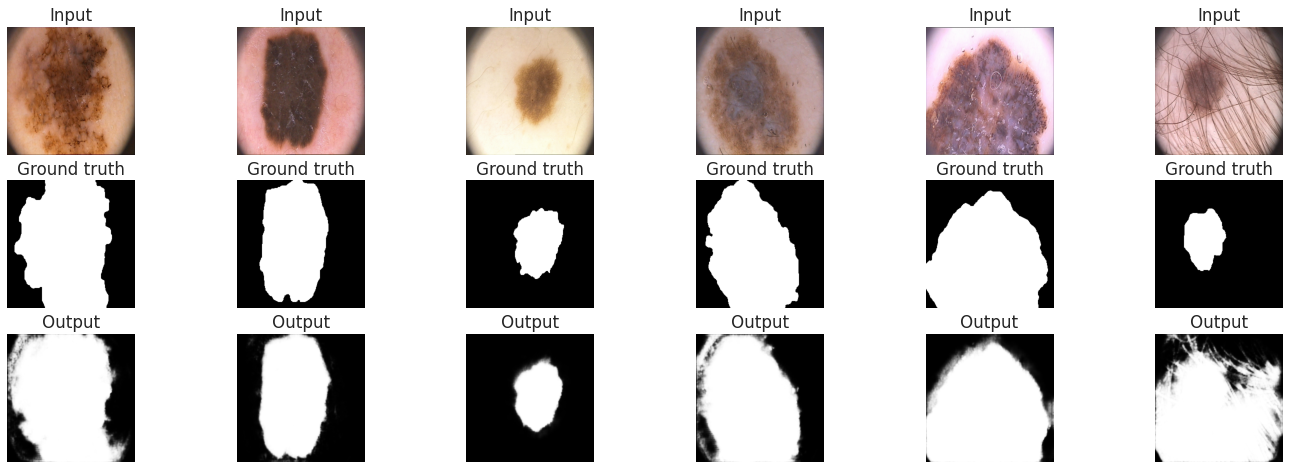

epoch: 100%|██████████| 100/100 [12:36<00:00,  7.57s/it]


In [ ]:
Segnet_combo, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Segnet_combo, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=combo_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Segnet_combo)

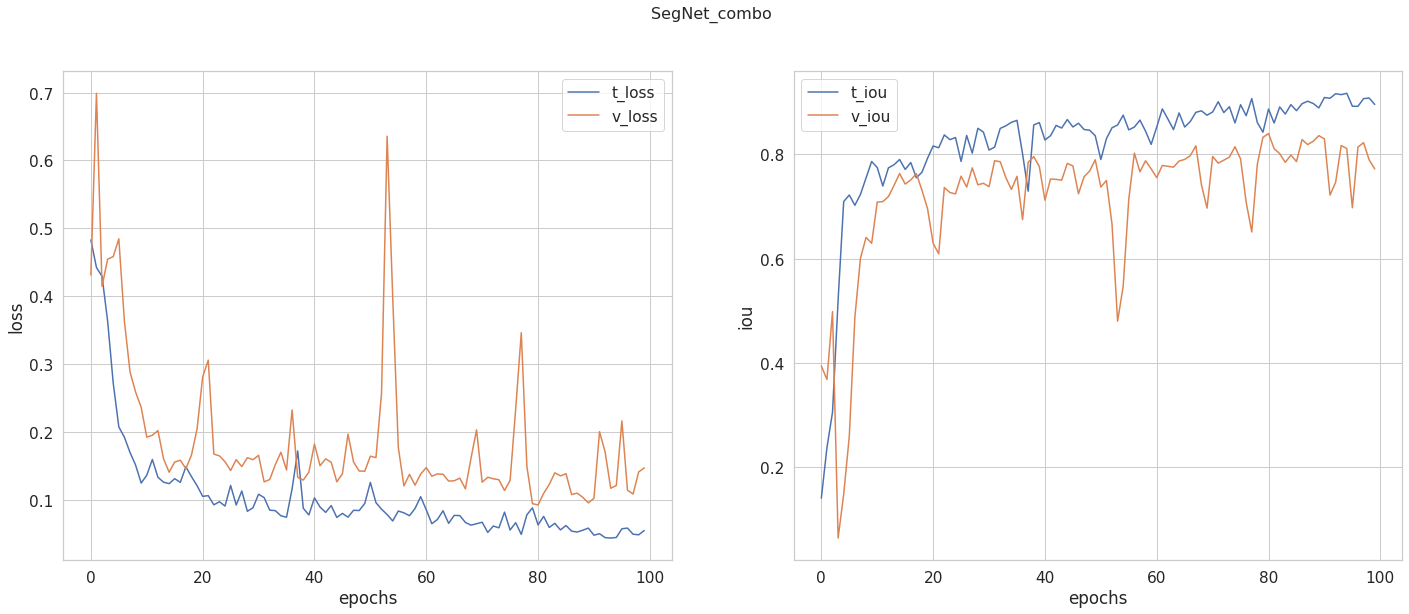

In [ ]:
# Визуализируем метрики
visual_metrics_dict('SegNet_combo')

In [ ]:
# Посмотрим сводную информацию о модели
edit_pivot(Segnet_combo, 'SegNet_combo', data_val, data_ts)

SegNet_bce SegNet_dice SegNet_focal SegNet_combo
loss_name    bce_loss   dice_loss   focal_loss   combo_loss
num_params   22361089    22361089     22361089     22361089
epochs            100         100          100          100
train_time        754         757          748          757
batch_size         25          25           25           25
best_epoch         93          93           92           81
best_time         699         702          686          612
iou_val        0.8328      0.8401       0.8135       0.8433
iou_test       0.8506      0.8199       0.8354       0.8114

По графикам видно, что модель не переобучается. Но после 80 эпохи лосс на валидации перестает снижаться. Имеет смысл попробовать продолжить обучение с маньшим learing rate. Моя модифицированная версия combo_loss показывает качество сегментации, сопоставимое с dice_loss, но достигает этого результата быстрее.

In [ ]:
# Запишем тестовое предсказание
write_predict(Segnet_combo, 'SegNet_combo')

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

# U-Net [2 балла]

----------------------------------------------------------------------------------------

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

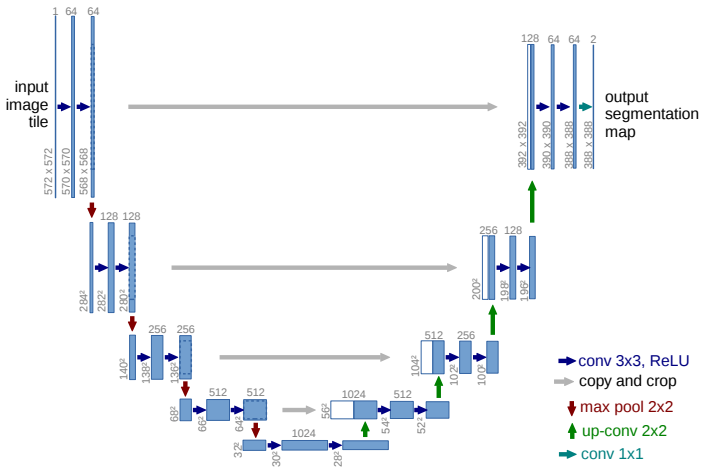

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

**UPD**\
В статье авторы пишут о том, что для "подгонки" размеров изображений при skip connection, используется crop. В моей реализации я не использовала crop, но использовала паддинги с padding_mode = 'reflect' и свертки не 2х2 перед UpSample, а свертки 1х1. Также, авторы UNet не используют BatchNorm, но я добавила, потому что считаю, что это улучшает сходимость.\
В первой версии получилось 28 956 481 параметров и память видеокарты переполнялась, поэтому я изменила слой bottlenek.

In [38]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        # pool и unpool везде имеют одинаковые параметры, не будем дублировать
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.unpool = nn.Upsample(scale_factor=2)

        self.enc_conv0 = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # self.pool0 =   # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )        
        # self.pool1 =  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )  
        # self.pool2 =  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # self.pool3 =  # 32 -> 16

        # bottleneck
        self.bottleneck = nn.Sequential(
            
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        

        # decoder (upsampling)
        # self.upsample0 =  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        # self.upsample1 =  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # self.upsample2 =   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # self.upsample3 =   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
            )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool(e0))
        e2 = self.enc_conv2(self.pool(e1))
        e3 = self.enc_conv3(self.pool(e2))
        
        # bottleneck
        b0 = self.bottleneck(self.pool(e3))
        
        # decoder
        d0 = self.unpool(b0)
        d1 = torch.cat((d0, e3), 1)
        d2 = self.unpool(self.dec_conv0(d1))
        d3 = torch.cat((d2, e2), 1)
        d4 = self.unpool(self.dec_conv1(d3))
        d5 = torch.cat((d4, e1), 1)
        d6 = self.unpool(self.dec_conv2(d5))
        d7 = torch.cat((d6, e0), 1)
        d8 = self.dec_conv3(d7)
      
        return d8

In [ ]:
import torchsummary

Unet_bce = UNet().to(DEVICE)

torchsummary.summary(Unet_bce, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

# UNet + bce_loss. До сходимости (для пояснения, почему условие сходимости было удалено из функции обучения)

In [ ]:
set_seed(2147483647)

Unet_bce = UNet().to(DEVICE)
model_name = 'UNet_bce'
num_params = sum(p.numel() for p in Unet_bce.parameters() if p.requires_grad)
max_epochs = 100

opt_Unet_bce = optim.Adam(params = Unet_bce.parameters(), lr=1e-3)

In [ ]:
batch_size = 10

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Fri May 14 14:52:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    37W / 250W |   1513MiB / 16280MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch:   5%|▌         | 5/100 [00:40<12:56,  8.18s/it]


Epoch 005  train_loss: 0.2505      val_loss 0.4329  train_iou 0.7259  val_iou 0.5599


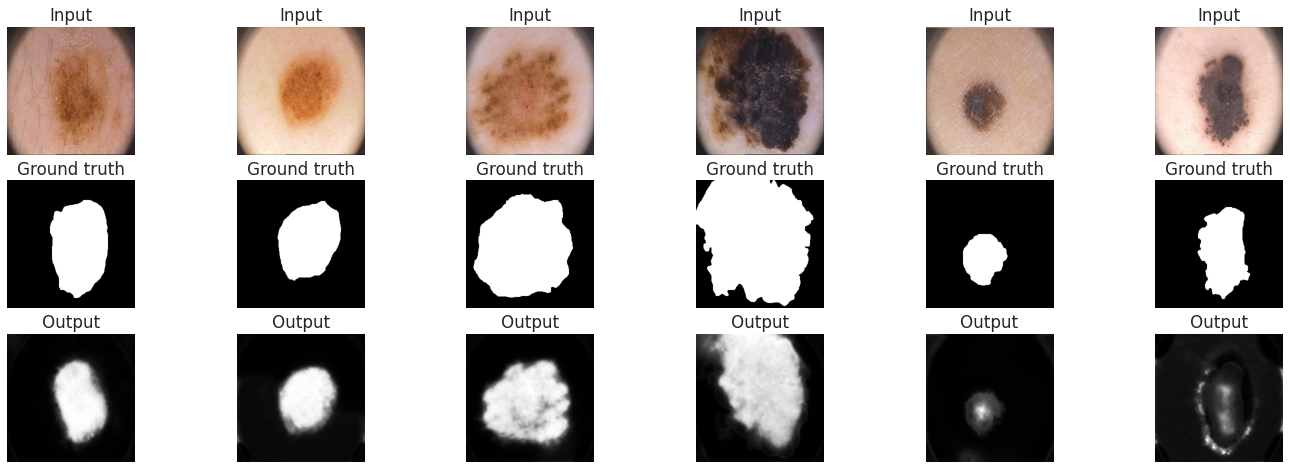

epoch:   5%|▌         | 5/100 [00:43<13:39,  8.63s/it]

Training complete in 0m 43s. Convergence
Best val iou: 0.559903


In [ ]:
Unet_bce, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Unet_bce, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=bce_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Unet_bce)

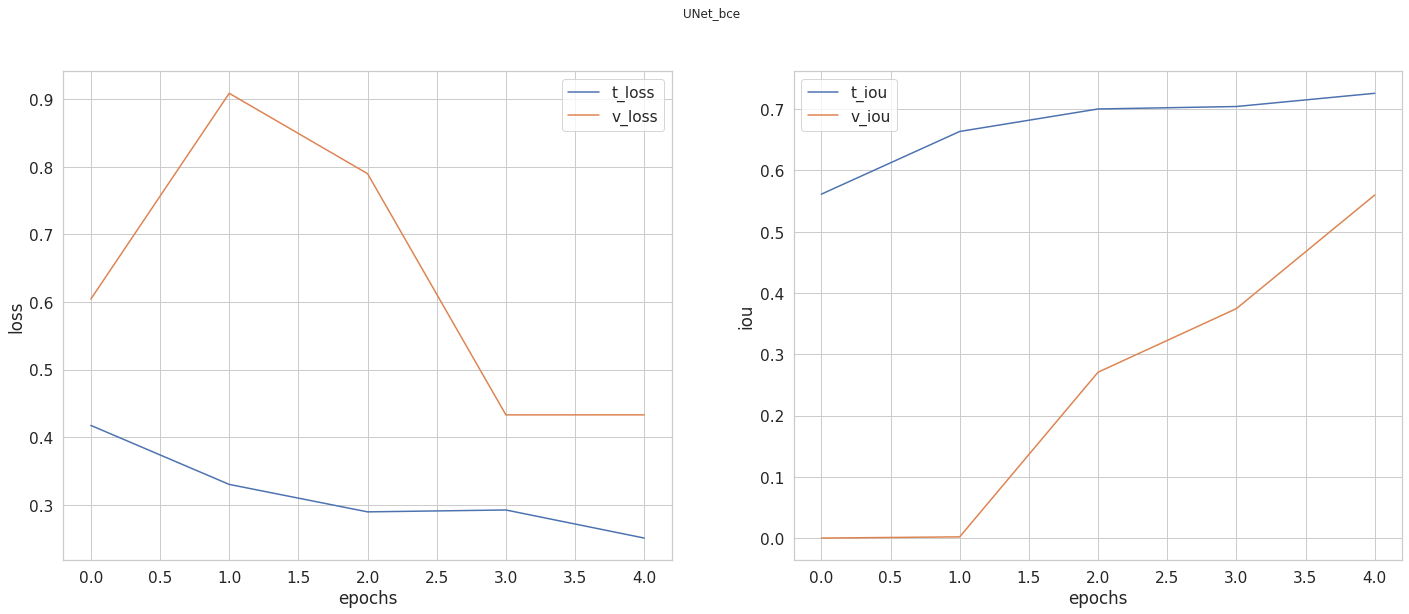

In [ ]:
# Визуализируем метрики
visual_metrics_dict('UNet_bce')

In [ ]:
# Посмотрим сводную информацию о модели
edit_pivot(Unet_bce, 'UNet_bce', data_val, data_ts)

# В таблице представлены результаты обучения SegNet с dice_loss до сходимости и
# результаты обучения SegNet с combo_loss, написанной по формуле из статьи, до сходимости.

SegNet_bce SegNet_dice SegNet_focal SegNet_combo  UNet_bce
loss_name    bce_loss   dice_loss   focal_loss   combo_loss  bce_loss
num_params   22361089    22361089     22361089     22361089  15713985
epochs            100          47          100           34         5
train_time        754         357          748          257        43
batch_size         25          25           25           25        10
best_epoch         93          40           92           11         5
best_time         699         302          686           84        40
iou_val        0.8328      0.7884       0.8135       0.5209    0.5549
iou_test       0.8506      0.8062       0.8354       0.5586    0.5269

Условие сходимости в функции обучения сработало на 5 эпохе. Модель не достигла своего лучшего качества. Делать выводы о переобучении нельзя. Уберем условие сходимости, и обучим модель заново.

# UNet + bce_loss. 100 эпох.

In [ ]:
set_seed(2147483647)

Unet_bce = UNet().to(DEVICE)
model_name = 'UNet_bce'
num_params = sum(p.numel() for p in Unet_bce.parameters() if p.requires_grad)
max_epochs = 100

opt_Unet_bce = optim.Adam(params = Unet_bce.parameters(), lr=1e-3)

In [ ]:
batch_size = 10

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Fri May 14 15:05:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |   1071MiB / 16280MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [13:47<00:00,  8.22s/it]


Epoch 100  train_loss: 0.0954      val_loss 0.1891  train_iou 0.8845  val_iou 0.8216


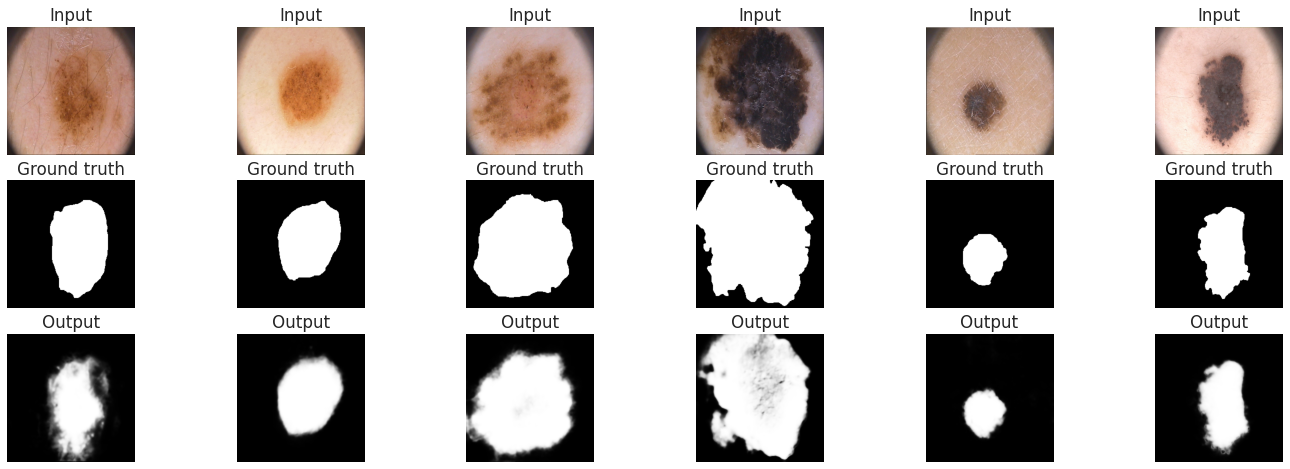

epoch: 100%|██████████| 100/100 [13:49<00:00,  8.30s/it]


In [ ]:
Unet_bce, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Unet_bce, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=bce_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Unet_bce)

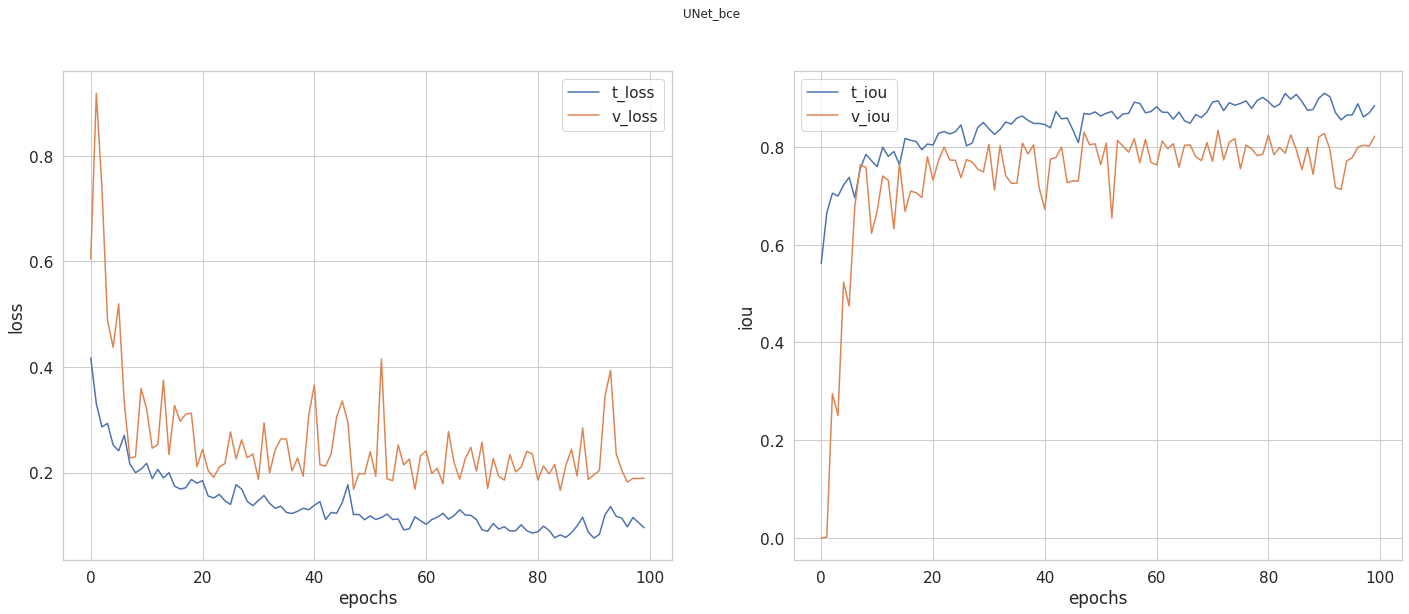

In [ ]:
# Визуализируем метрики
visual_metrics_dict('UNet_bce')

In [ ]:
# Посмотрим сводную информацию о модели
edit_pivot(Unet_bce, 'UNet_bce', data_val, data_ts)

SegNet_bce SegNet_dice SegNet_focal SegNet_combo  UNet_bce
loss_name    bce_loss   dice_loss   focal_loss   combo_loss  bce_loss
num_params   22361089    22361089     22361089     22361089  15713985
epochs            100         100          100          100       100
train_time        754         757          748          757       830
batch_size         25          25           25           25        10
best_epoch         93          93           92           81        72
best_time         699         702          686          612       596
iou_val        0.8328      0.8401       0.8135       0.8433    0.8295
iou_test       0.8506      0.8199       0.8354       0.8114    0.8652

Судя по графикам, переобучение модели не происходит. UNet показывает в целом выше качество предсказаний и большую уверенность в них в сравнении с SegNet. Лучшее качество модели по метрике на валидации достигается на 72 эпохе (у SegNet c той же функцией потерь на 93). График лосса неравномерный. Вероятно, это связано с размером батча и шагом градиентного спуска. Но больший размер батча не уместился в память, а шаг градиентного спуска был эксперементально подобран на SegNet и зафиксирован для всех экспериментов.

In [ ]:
# Запишем тестовое предсказание
write_predict(Unet_bce, 'UNet_bce')

# UNet + dice_loss. 100 эпох.

In [ ]:
set_seed(2147483647)

Unet_dice = UNet().to(DEVICE)
model_name = 'UNet_dice'
num_params = sum(p.numel() for p in Unet_dice.parameters() if p.requires_grad)
max_epochs = 100

opt_Unet_dice = optim.Adam(params = Unet_dice.parameters(), lr=1e-3)

In [ ]:
batch_size = 10

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Fri May 14 15:41:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |   1239MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [13:46<00:00,  8.24s/it]


Epoch 100  train_loss: 0.0508      val_loss 0.0965  train_iou 0.9045  val_iou 0.8257


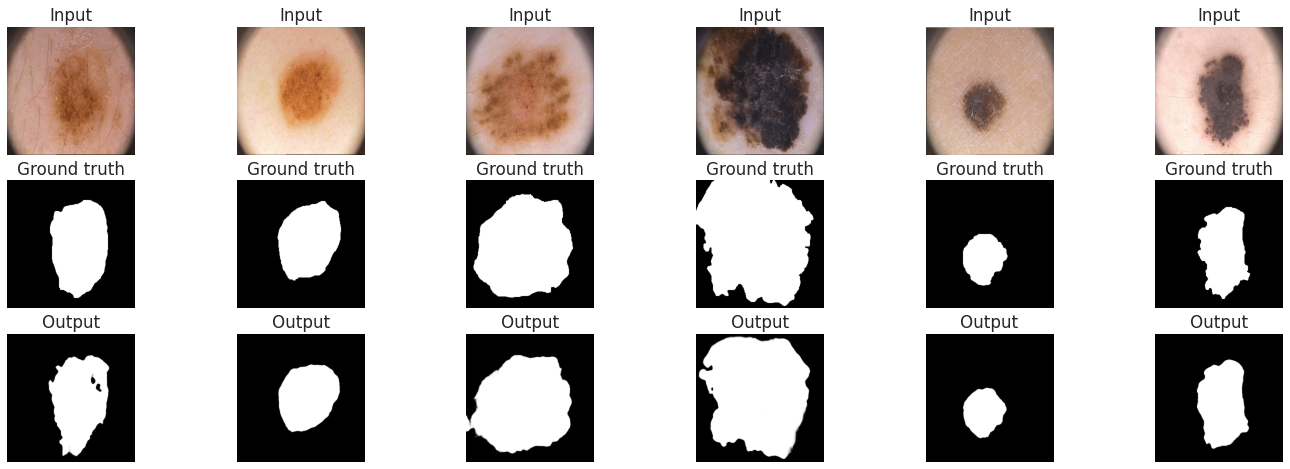

epoch: 100%|██████████| 100/100 [13:48<00:00,  8.28s/it]


In [ ]:
Unet_dice, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Unet_dice, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=dice_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Unet_dice)

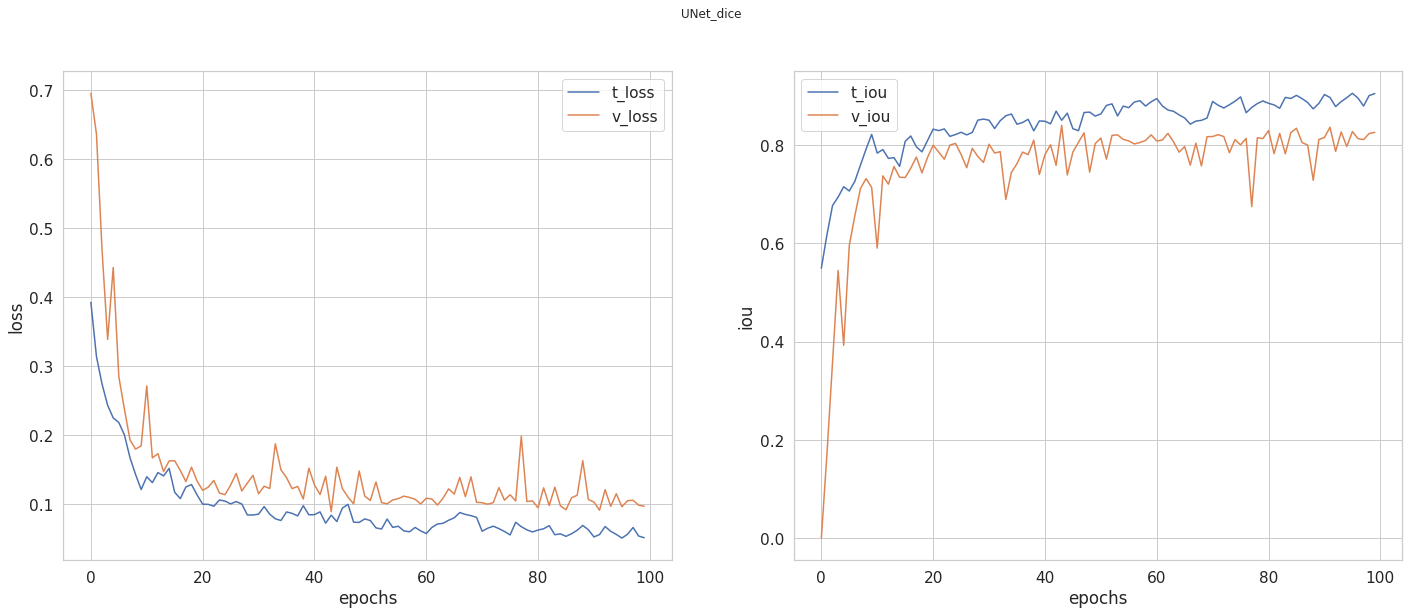

In [ ]:
# Визуализируем метрики
visual_metrics_dict('UNet_dice')

In [ ]:
# Посмотрим сводную информацию о модели
edit_pivot(Unet_dice, 'UNet_dice', data_val, data_ts)

SegNet_bce SegNet_dice  ...  UNet_bce  UNet_dice
loss_name    bce_loss   dice_loss  ...  bce_loss  dice_loss
num_params   22361089    22361089  ...  15713985   15713985
epochs            100         100  ...       100        100
train_time        754         757  ...       830        828
batch_size         25          25  ...        10         10
best_epoch         93          93  ...        72         44
best_time         699         702  ...       596        365
iou_val        0.8328      0.8401  ...    0.8295     0.8328
iou_test       0.8506      0.8199  ...    0.8652     0.8612

[9 rows x 6 columns]

По графикам очевидно, что обучение после 50 эпохи уже не вносит существенного вклада в снижение лосса или повышения качества предсказаний. Модель не переобучается. График лоссов более "гладкий", чем с bce_loss. Модель раньше достигает своего лучшего значения, и более уверена, в предсказаниях.

In [ ]:
# Запишем тестовое предсказание
write_predict(Unet_dice, 'UNet_dice')

# UNet + focal_loss. 100 эпох.

In [ ]:
set_seed(2147483647)

Unet_focal = UNet().to(DEVICE)
model_name = 'UNet_focal'
num_params = sum(p.numel() for p in Unet_focal.parameters() if p.requires_grad)
max_epochs = 100

opt_Unet_focal = optim.Adam(params = Unet_focal.parameters(), lr=1e-3)

In [ ]:
batch_size = 10

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Fri May 14 16:06:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    36W / 250W |   1649MiB / 16280MiB |     60%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [13:47<00:00,  8.24s/it]


Epoch 100  train_loss: 0.0537      val_loss 0.1558  train_iou 0.8971  val_iou 0.7990


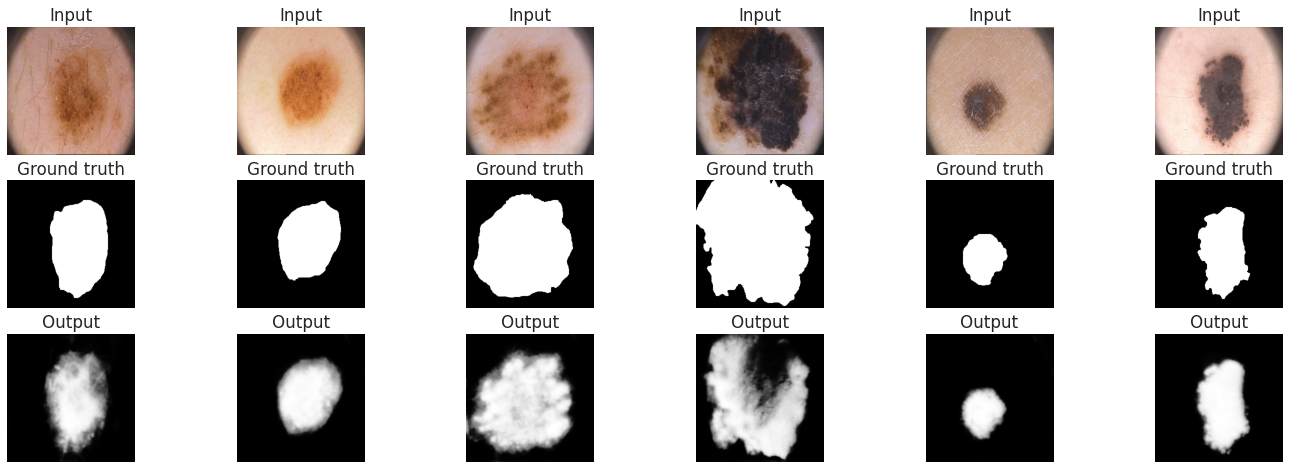

epoch: 100%|██████████| 100/100 [13:49<00:00,  8.29s/it]


In [ ]:
Unet_focal, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Unet_focal, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=focal_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Unet_focal)

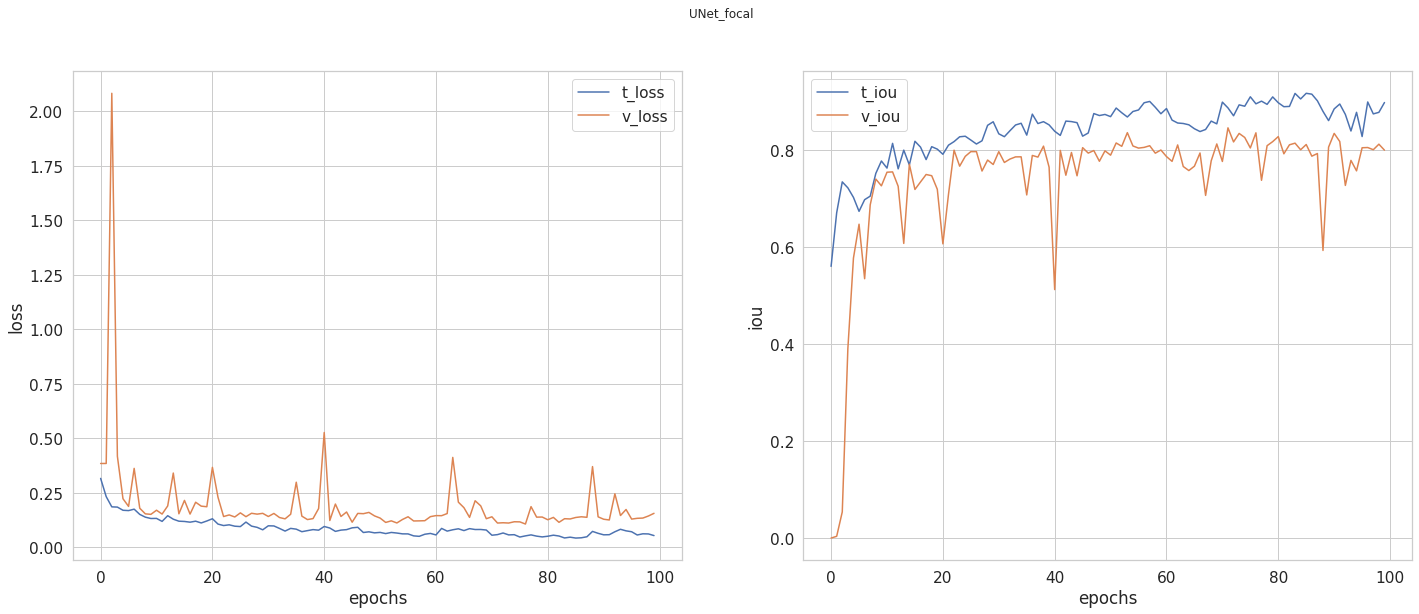

In [ ]:
# Визуализируем метрики
visual_metrics_dict('UNet_focal')

In [ ]:
# Посмотрим сводную информацию о модели
edit_pivot(Unet_focal, 'UNet_focal', data_val, data_ts)

SegNet_bce SegNet_dice SegNet_focal  ...  UNet_bce  UNet_dice  UNet_focal
loss_name    bce_loss   dice_loss   focal_loss  ...  bce_loss  dice_loss  focal_loss
num_params   22361089    22361089     22361089  ...  15713985   15713985    15713985
epochs            100         100          100  ...       100        100         100
train_time        754         757          748  ...       830        828         829
batch_size         25          25           25  ...        10         10          10
best_epoch         93          93           92  ...        72         44          72
best_time         699         702          686  ...       596        365         595
iou_val        0.8328      0.8401       0.8135  ...    0.8295     0.8328      0.8388
iou_test       0.8506      0.8199       0.8354  ...    0.8652     0.8612      0.8584

[9 rows x 7 columns]

Модель не переобучается, но дальше 50 эпохи имеет смысл менять параментры обучения, чтобы улучшить качество.

In [ ]:
# Запишем тестовое предсказание
write_predict(Unet_focal, 'UNet_focal')

# UNet + combo_loss. 100 эпох.

In [ ]:
set_seed(2147483647)

Unet_combo = UNet().to(DEVICE)
model_name = 'UNet_combo'
num_params = sum(p.numel() for p in Unet_combo.parameters() if p.requires_grad)
max_epochs = 100

opt_Unet_combo = optim.Adam(params = Unet_combo.parameters(), lr=1e-3)

In [ ]:
batch_size = 10

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sat May 15 13:45:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    41W / 250W |  10285MiB / 16280MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [14:00<00:00,  8.35s/it]


Epoch 100  train_loss: 0.0550      val_loss 0.2233  train_iou 0.8996  val_iou 0.6630


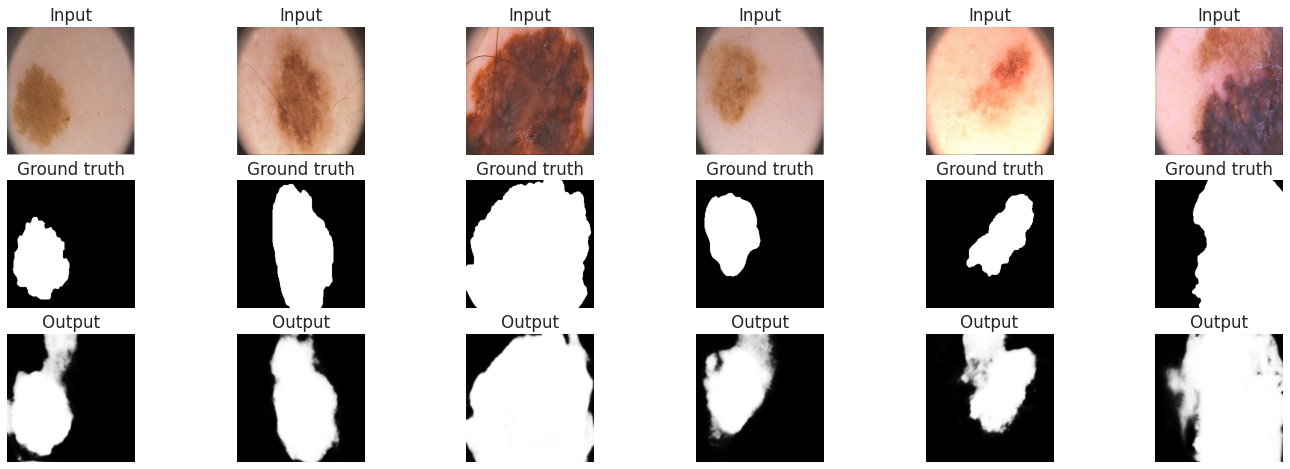

epoch: 100%|██████████| 100/100 [14:02<00:00,  8.43s/it]


In [ ]:
Unet_combo, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Unet_combo, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=combo_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Unet_combo)

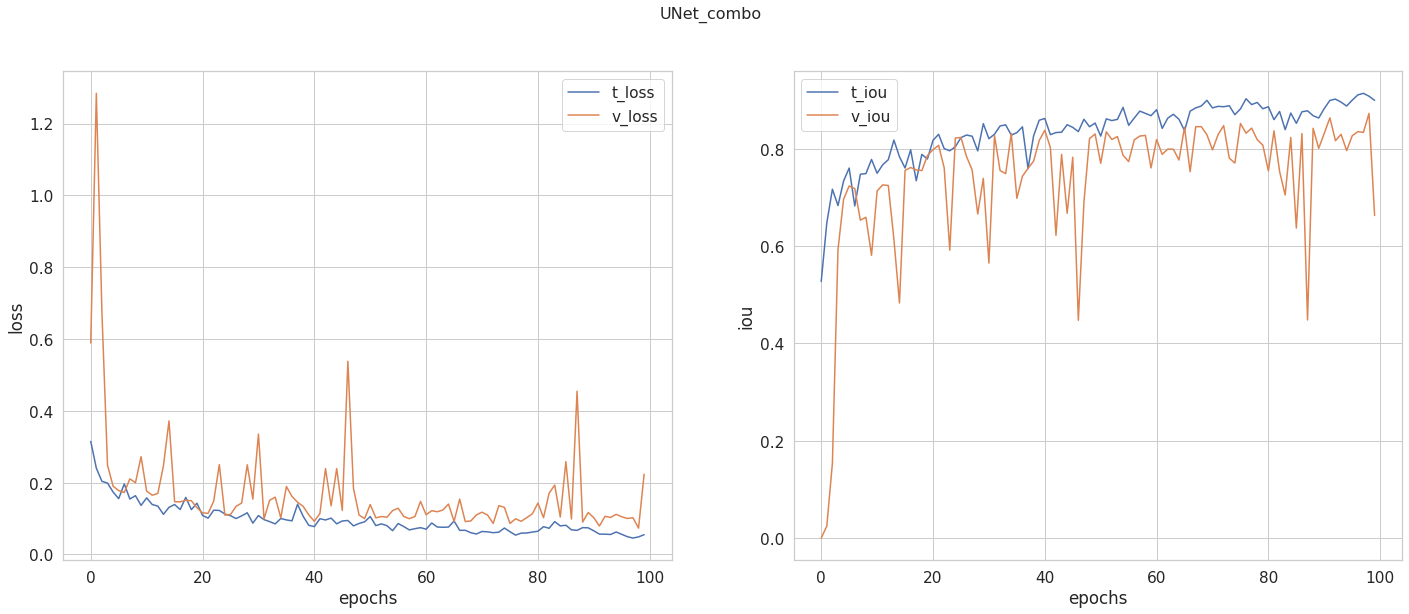

In [ ]:
# Визуализируем метрики
visual_metrics_dict('UNet_combo')

In [ ]:
# Посмотрим сводную информацию о модели
edit_pivot(Unet_combo, 'UNet_combo', data_val, data_ts)

SegNet_bce SegNet_dice  ...  UNet_focal  UNet_combo
loss_name    bce_loss   dice_loss  ...  focal_loss  combo_loss
num_params   22361089    22361089  ...    15713985    15713985
epochs            100         100  ...         100         100
train_time        754         757  ...         829         843
batch_size         25          25  ...          10          10
best_epoch         93          93  ...          72          99
best_time         699         702  ...         595         831
iou_val        0.8328      0.8401  ...      0.8388      0.8735
iou_test       0.8506      0.8199  ...      0.8584       0.849

[9 rows x 8 columns]

По графикам видно, что модель не переобучается, метрика растет, лосс снижается. Имеет смысл попробовать продолжить обучение с меньшим learning rate.

In [ ]:
# Запишем тестовое предсказание
write_predict(Unet_combo, 'UNet_combo')

---------------------------------------------------------------------------------------------------------------------------------

# UNet2

Задание: Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.

In [39]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # self.pool0 =   # 256 -> 128
        self.pool0 = nn.Sequential(
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )


        self.enc_conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )        
        # self.pool1 =  # 128 -> 64
        self.pool1 = nn.Sequential(
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )


        self.enc_conv2 = nn.Sequential(
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )  
        # self.pool2 =  # 64 -> 32
        self.pool2 = nn.Sequential(
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.enc_conv3 = nn.Sequential(
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # self.pool3 =  # 32 -> 16
        self.pool3 = nn.Sequential(
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck = nn.Sequential(
            
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        

        # decoder (upsampling)
        # self.upsample0 =  # 16 -> 32
        self.upsample0 = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.dec_conv0 = nn.Sequential(
            
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # self.upsample1 =  # 32 -> 64
        self.upsample1 = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
       
        self.dec_conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # self.upsample2 =   # 64 -> 128
        self.upsample2 = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dec_conv2 = nn.Sequential(
            
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # self.upsample3 =   # 128 -> 256
        self.upsample3 = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.dec_conv3 = nn.Sequential(
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
            )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))
        
        # bottleneck
        b = self.bottleneck(self.pool3(e3))
        
        # decoder
        d0 = self.upsample0(b)
        d1 = torch.cat((d0, e3), 1)
        d2 = self.upsample1(self.dec_conv0(d1))
        d3 = torch.cat((d2, e2), 1)
        d4 = self.upsample2(self.dec_conv1(d3))
        d5 = torch.cat((d4, e1), 1)
        d6 = self.upsample3(self.dec_conv2(d5))
        d7 = torch.cat((d6, e0), 1)
        d8 = self.dec_conv3(d7)
        
        return d8

In [29]:
import torchsummary

Unet2_bce = UNet2().to(DEVICE)

torchsummary.summary(Unet2_bce, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7         [-1, 64, 128, 128]          16,448
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14        [-1, 128, 1

# UNet2 + bce_loss. 100 эпох.

In [31]:
set_seed(2147483647)

Unet2_bce = UNet2().to(DEVICE)
model_name = 'UNet2_bce'
num_params = sum(p.numel() for p in Unet2_bce.parameters() if p.requires_grad)
max_epochs = 100

opt_Unet2_bce = optim.Adam(params = Unet2_bce.parameters(), lr=1e-3)

In [32]:
batch_size = 10

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [33]:
torch.cuda.empty_cache()
!nvidia-smi

Sun May 16 07:42:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |    995MiB / 16280MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [14:31<00:00,  8.65s/it]


Epoch 100  train_loss: 0.1149      val_loss 0.7837  train_iou 0.8665  val_iou 0.5164


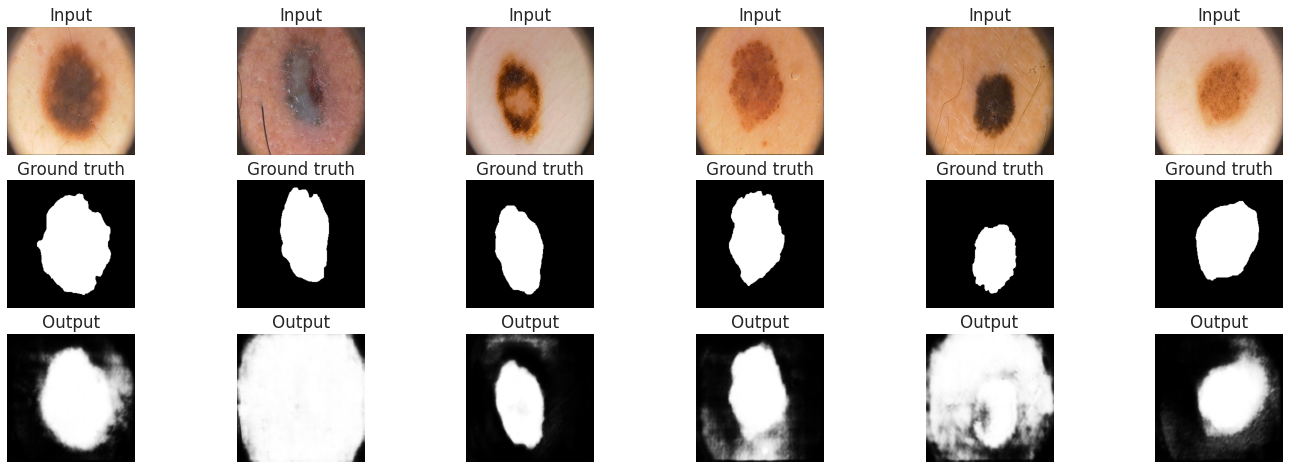

epoch: 100%|██████████| 100/100 [14:33<00:00,  8.73s/it]


In [34]:
Unet2_bce, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Unet2_bce, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=bce_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Unet2_bce)

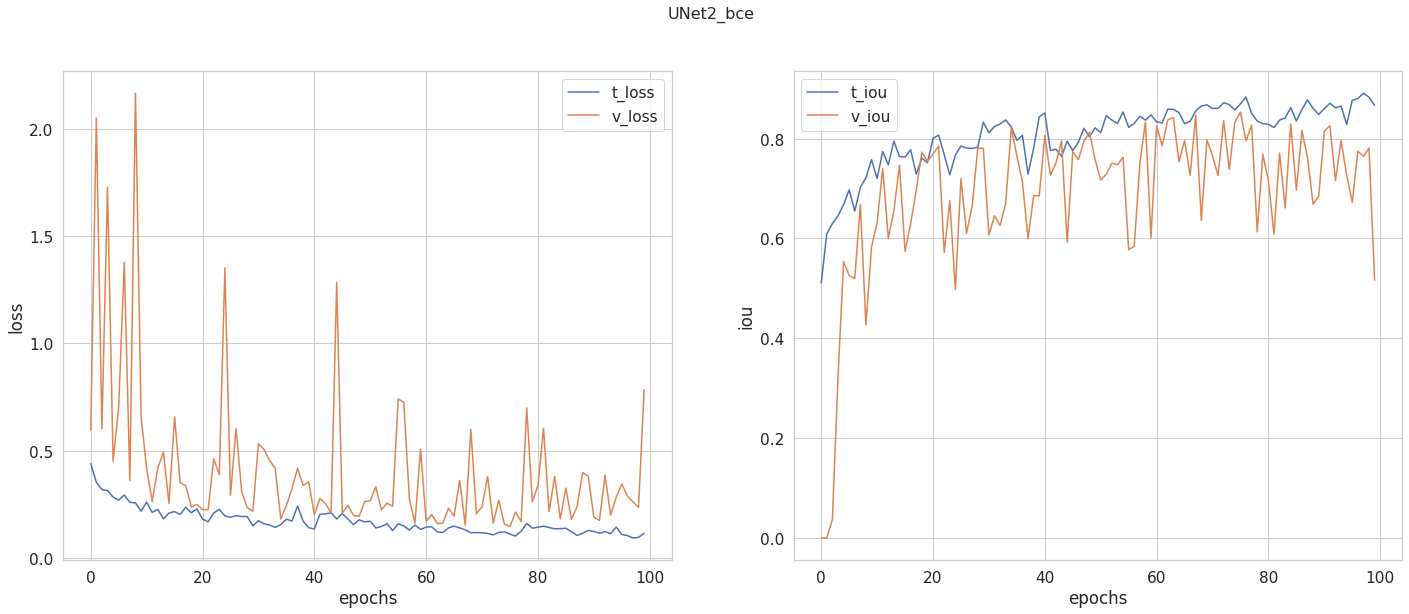

In [35]:
# Визуализируем метрики
visual_metrics_dict('UNet2_bce')

Модель не переобучается, что графики лосса и метрики на валидации очень не стабильны. Модель не уверена в предсказаниях.

In [36]:
# Посмотрим сводную информацию о модели
edit_pivot(Unet2_bce, 'UNet2_bce', data_val, data_ts)

SegNet_bce SegNet_dice  ...  UNet_combo UNet2_bce
loss_name    bce_loss   dice_loss  ...  combo_loss  bce_loss
num_params   22361089    22361089  ...    15713985  18412033
epochs            100         100  ...         100       100
train_time        754         757  ...         843       873
batch_size         25          25  ...          10        10
best_epoch         93          93  ...          99        76
best_time         699         702  ...         831       663
iou_val        0.8328      0.8401  ...      0.8735    0.8482
iou_test       0.8506      0.8199  ...       0.849    0.8378

[9 rows x 9 columns]

График лоссов и метрик на валидации очень нестабильный. Вероятно, это из-за малого размера батча (но больший в моем случае не уместился в память cuda). Однако, постепенно качество предсказаний увеличивается. Имеет смысл попробовать продолжить обучение с меньшим learning rate.

In [37]:
# Запишем тестовое предсказание
write_predict(Unet2_bce, 'UNet2_bce')

# UNet2 + dice_loss. 100 эпох.

In [38]:
set_seed(2147483647)

Unet2_dice = UNet2().to(DEVICE)
model_name = 'UNet2_dice'
num_params = sum(p.numel() for p in Unet2_dice.parameters() if p.requires_grad)
max_epochs = 100

opt_Unet2_dice = optim.Adam(params = Unet2_dice.parameters(), lr=1e-3)

In [39]:
batch_size = 10

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [40]:
torch.cuda.empty_cache()
!nvidia-smi

Sun May 16 08:03:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    38W / 250W |   1605MiB / 16280MiB |     58%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [14:30<00:00,  8.70s/it]


Epoch 100  train_loss: 0.0719      val_loss 0.1662  train_iou 0.8686  val_iou 0.7176


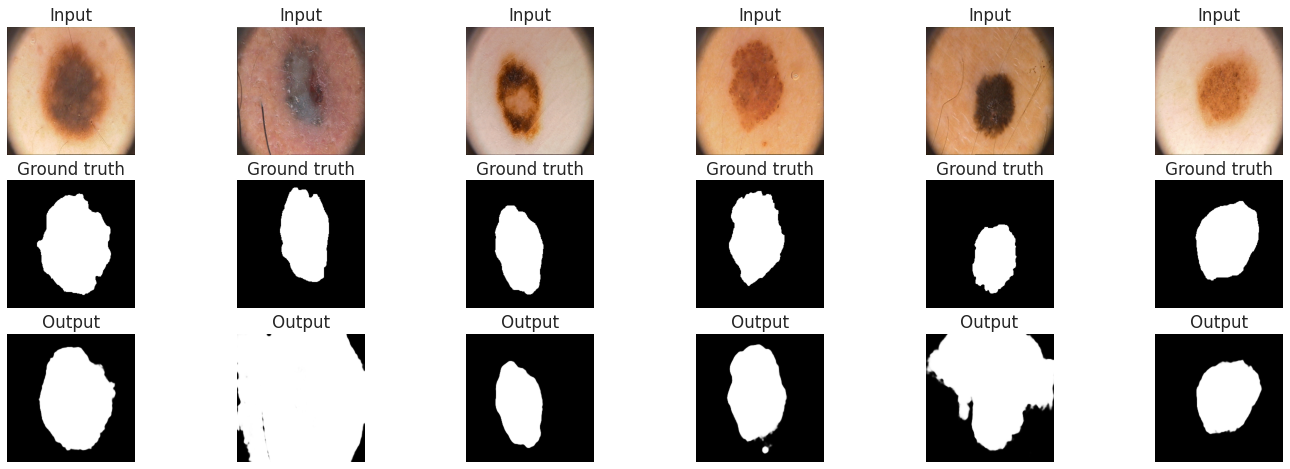

epoch: 100%|██████████| 100/100 [14:32<00:00,  8.73s/it]


In [41]:
Unet2_dice, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Unet2_dice, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=dice_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Unet2_dice)

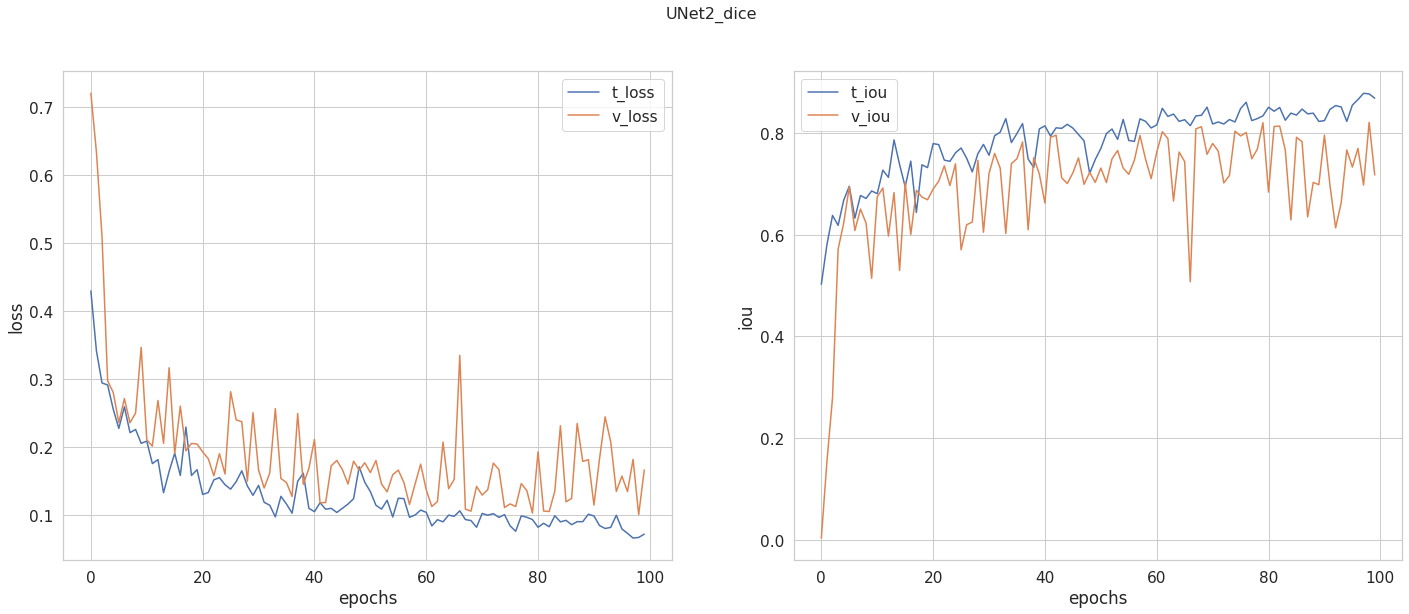

In [42]:
# Визуализируем метрики
visual_metrics_dict('UNet2_dice')

Обучения не происходит. Модель более уверена в предсказаниях, чем с функцией потерь bce_loss. Графики лосса и метрики очень не стабильные.

In [43]:
# Посмотрим сводную информацию о модели
edit_pivot(Unet2_dice, 'UNet2_dice', data_val, data_ts)

SegNet_bce SegNet_dice SegNet_focal  ...  UNet_combo UNet2_bce UNet2_dice
loss_name    bce_loss   dice_loss   focal_loss  ...  combo_loss  bce_loss  dice_loss
num_params   22361089    22361089     22361089  ...    15713985  18412033   18412033
epochs            100         100          100  ...         100       100        100
train_time        754         757          748  ...         843       873        873
batch_size         25          25           25  ...          10        10         10
best_epoch         93          93           92  ...          99        76         99
best_time         699         702          686  ...         831       663        862
iou_val        0.8328      0.8401       0.8135  ...      0.8735    0.8482     0.8296
iou_test       0.8506      0.8199       0.8354  ...       0.849    0.8378     0.8173

[9 rows x 10 columns]

Модель не переобучается, т.к. графики лоссов и метрик "движутся" в унисон. Однако, наблюдается высокая нестабильность показателей. Лучшая эпоха - 99, значит имеет смысл продолжать обучение, но с меньшим learning rate и на большем размере батча.

In [45]:
# Запишем тестовое предсказание
write_predict(Unet2_dice, 'UNet2_dice')

# UNet2 + focal_loss. 100 эпох.

In [46]:
set_seed(2147483647)

Unet2_focal = UNet2().to(DEVICE)
model_name = 'UNet2_focal'
num_params = sum(p.numel() for p in Unet2_focal.parameters() if p.requires_grad)
max_epochs = 100

opt_Unet2_focal = optim.Adam(params = Unet2_focal.parameters(), lr=1e-3)

In [47]:
batch_size = 10

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [48]:
torch.cuda.empty_cache()
!nvidia-smi

Sun May 16 08:21:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    39W / 250W |   2373MiB / 16280MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [14:31<00:00,  8.72s/it]


Epoch 100  train_loss: 0.0824      val_loss 0.2513  train_iou 0.8443  val_iou 0.6795


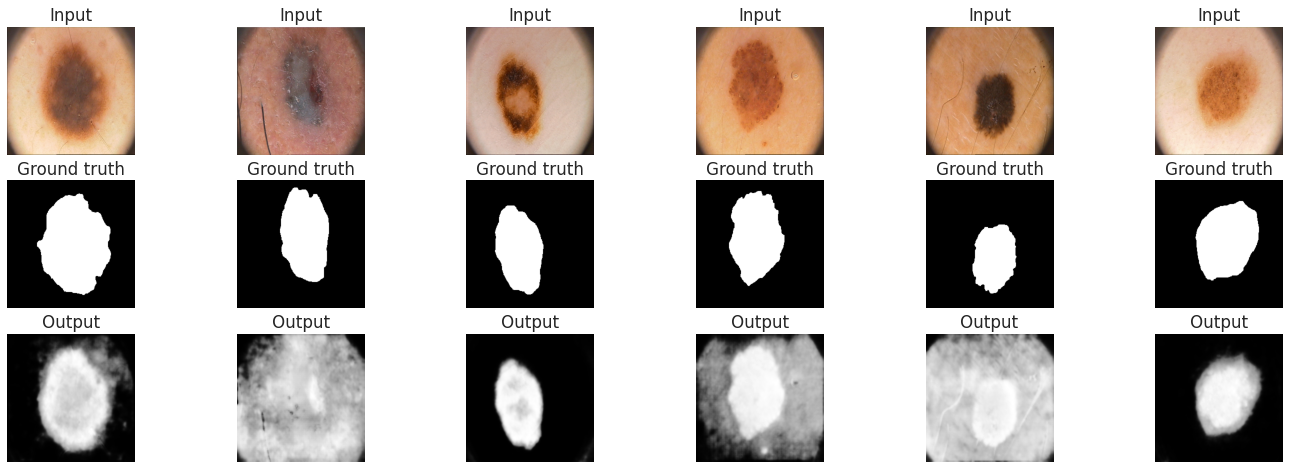

epoch: 100%|██████████| 100/100 [14:33<00:00,  8.73s/it]


In [49]:
Unet2_focal, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Unet2_focal, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=focal_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Unet2_focal)

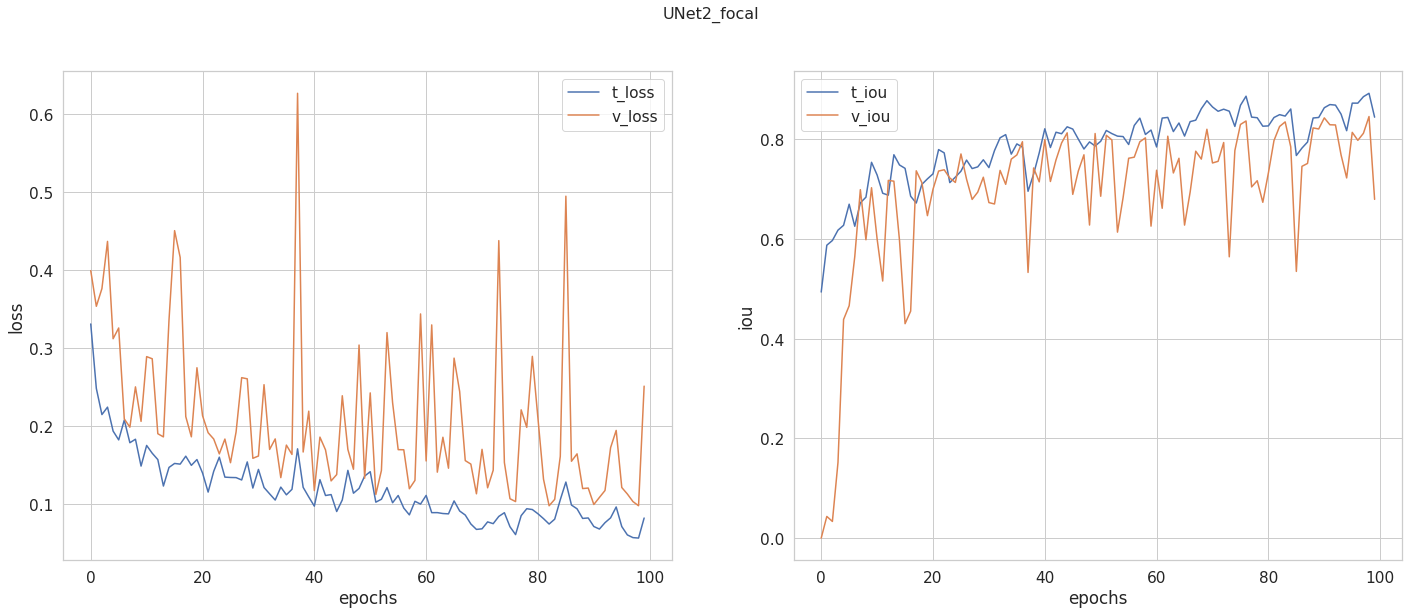

In [50]:
# Визуализируем метрики
visual_metrics_dict('UNet2_focal')

Не смотря на отсутствие переобучения, графики лосса и метрики очень не стабильные. Имеет смысл пробовать менять параметры обучения. Кроме того, модель не уверена в предсказаниях.

In [51]:
# Посмотрим сводную информацию о модели
edit_pivot(Unet2_focal, 'UNet2_focal', data_val, data_ts)

SegNet_bce SegNet_dice SegNet_focal  ... UNet2_bce UNet2_dice UNet2_focal
loss_name    bce_loss   dice_loss   focal_loss  ...  bce_loss  dice_loss  focal_loss
num_params   22361089    22361089     22361089  ...  18412033   18412033    18412033
epochs            100         100          100  ...       100        100         100
train_time        754         757          748  ...       873        873         873
batch_size         25          25           25  ...        10         10          10
best_epoch         93          93           92  ...        76         99          99
best_time         699         702          686  ...       663        862         862
iou_val        0.8328      0.8401       0.8135  ...    0.8482     0.8296      0.8467
iou_test       0.8506      0.8199       0.8354  ...    0.8378     0.8173      0.8276

[9 rows x 11 columns]

Модель не переобучается, но графики лоссов и метрик очень не стабильны. Имеет смысл попробовать продолжить обучение с меньшим learning rate и большим размером батча

In [52]:
# Запишем тестовое предсказание
write_predict(Unet2_focal, 'UNet2_focal')

# UNet2 + combo_loss. 100 эпох.

In [53]:
set_seed(2147483647)

Unet2_combo = UNet2().to(DEVICE)
model_name = 'UNet2_combo'
num_params = sum(p.numel() for p in Unet2_combo.parameters() if p.requires_grad)
max_epochs = 100

opt_Unet2_combo = optim.Adam(params = Unet2_combo.parameters(), lr=1e-3)

In [54]:
batch_size = 10

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

data_tr = DataLoader(list(zip(np.rollaxis(X[dict_ind['tr']], 3, 1), Y[dict_ind['tr'], np.newaxis])), 
                     batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_val = DataLoader(list(zip(np.rollaxis(X[dict_ind['val']], 3, 1), Y[dict_ind['val'], np.newaxis])),
                      batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
data_ts = DataLoader(list(zip(np.rollaxis(X[dict_ind['ts']], 3, 1), Y[dict_ind['ts'], np.newaxis])),
                     batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

In [55]:
torch.cuda.empty_cache()
!nvidia-smi

Sun May 16 08:39:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    39W / 250W |   3007MiB / 16280MiB |     73%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch: 100%|██████████| 100/100 [14:32<00:00,  8.69s/it]


Epoch 100  train_loss: 0.0783      val_loss 0.2792  train_iou 0.8621  val_iou 0.6071


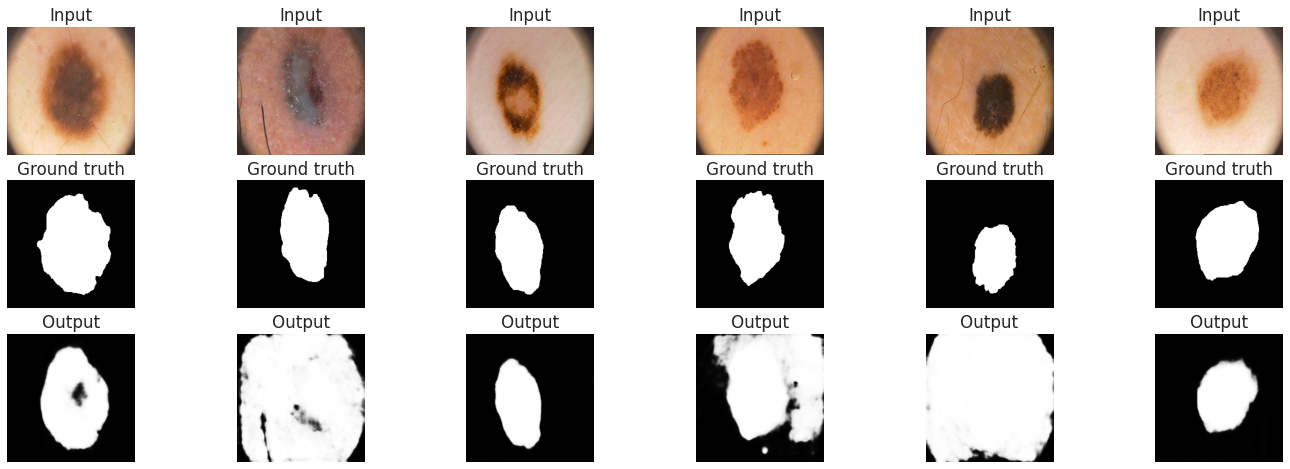

epoch: 100%|██████████| 100/100 [14:34<00:00,  8.74s/it]


In [56]:
Unet2_combo, dict_metrics = train_model(train_loader=data_tr, 
                              val_loader=data_val, 
                              model=Unet2_combo, 
                              model_name=model_name, 
                              num_params=num_params, 
                              batch_size=batch_size, 
                              epochs=max_epochs, 
                              loss_fn=combo_loss,
                              metric = iou_pytorch, 
                              optimizer=opt_Unet2_combo)

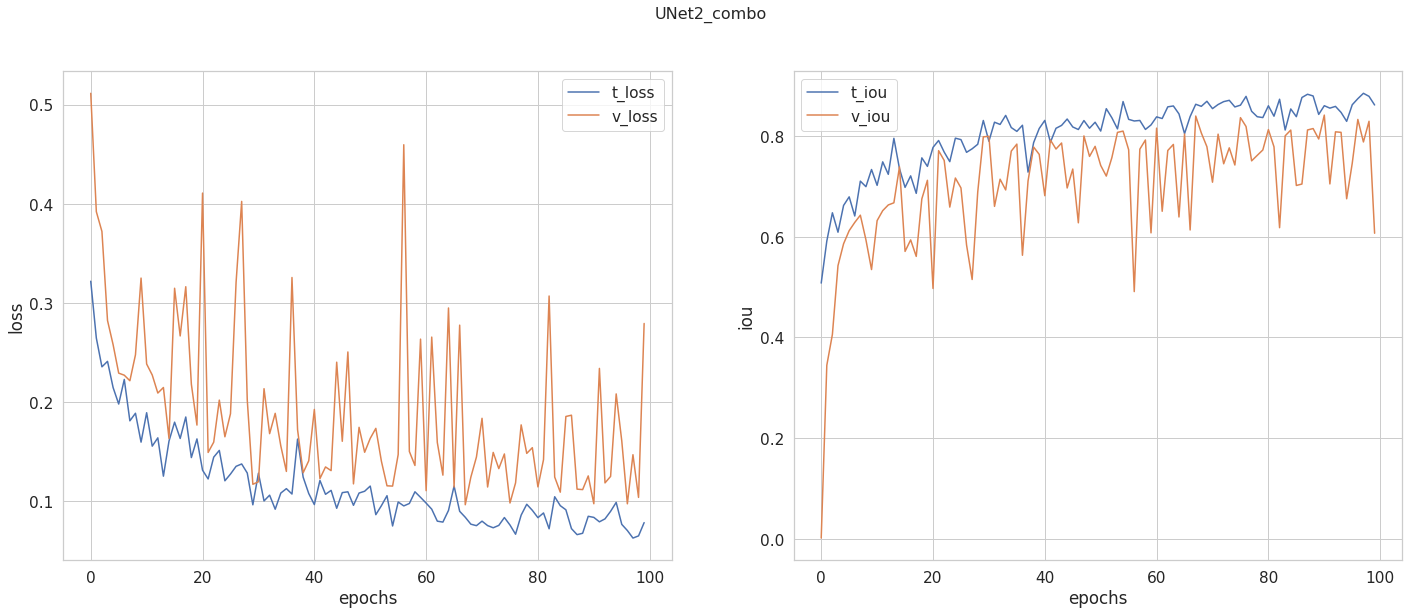

In [57]:
# Визуализируем метрики
visual_metrics_dict('UNet2_combo')

Аналогично предыдущей функции потерь, и в целом по архитектуре данной модели, графики лосса и метрики на валидации не стабильны, существенного прироста качества не происходит. 

In [58]:
# Посмотрим сводную информацию о модели
edit_pivot(Unet2_combo, 'UNet2_combo', data_val, data_ts)

SegNet_bce SegNet_dice  ... UNet2_focal UNet2_combo
loss_name    bce_loss   dice_loss  ...  focal_loss  combo_loss
num_params   22361089    22361089  ...    18412033    18412033
epochs            100         100  ...         100         100
train_time        754         757  ...         873         874
batch_size         25          25  ...          10          10
best_epoch         93          93  ...          99          91
best_time         699         702  ...         862         793
iou_val        0.8328      0.8401  ...      0.8467      0.8419
iou_test       0.8506      0.8199  ...      0.8276      0.7943

[9 rows x 12 columns]

In [59]:
# Запишем тестовое предсказание
write_predict(Unet2_combo, 'UNet2_combo')

# Отчет (6 баллов):

После многочисленных экспериментов, к рассмотрению в моей работе представлено 12 нейронных сетей (3 архитектуры, 4 функции потерь). Все сети обучались на одинаковых датасетах (деление на обучающую, валидационную и тестовую выборки происходили одинаково). В качестве оптимизатора выбран torch.optim.Adam (стохастический градиентный спуск по алгоритму Adam) с шагом градиентного спуска 1e-3. Обучение длилось 100 эпох. Качество сегментации оценивалось по метрике IOU. 

Для сравнения результатов построим несколько графиков и отрисуем предсказания моделей

In [42]:
# Загрузим словари лоссов и метрик моделей
# SegNet
with open(os.path.join(DATA_DIR, 'SegNet_bce_loss_table.pickle'), 'rb') as f:
  dict_Segnet_bce = pickle.load(f)

with open(os.path.join(DATA_DIR, 'SegNet_dice_loss_table.pickle'), 'rb') as f:
  dict_Segnet_dice = pickle.load(f)

with open(os.path.join(DATA_DIR, 'SegNet_focal_loss_table.pickle'), 'rb') as f:
  dict_Segnet_focal = pickle.load(f)

with open(os.path.join(DATA_DIR, 'SegNet_combo_loss_table.pickle'), 'rb') as f:
  dict_Segnet_combo = pickle.load(f)

# UNet
with open(os.path.join(DATA_DIR, 'UNet_bce_loss_table.pickle'), 'rb') as f:
  dict_Unet_bce = pickle.load(f)

with open(os.path.join(DATA_DIR, 'UNet_dice_loss_table.pickle'), 'rb') as f:
  dict_Unet_dice = pickle.load(f)

with open(os.path.join(DATA_DIR, 'UNet_focal_loss_table.pickle'), 'rb') as f:
  dict_Unet_focal = pickle.load(f)

with open(os.path.join(DATA_DIR, 'UNet_combo_loss_table.pickle'), 'rb') as f:
  dict_Unet_combo = pickle.load(f)

# UNet2
with open(os.path.join(DATA_DIR, 'UNet2_bce_loss_table.pickle'), 'rb') as f:
  dict_Unet2_bce = pickle.load(f)

with open(os.path.join(DATA_DIR, 'UNet2_dice_loss_table.pickle'), 'rb') as f:
  dict_Unet2_dice = pickle.load(f)

with open(os.path.join(DATA_DIR, 'UNet2_focal_loss_table.pickle'), 'rb') as f:
  dict_Unet2_focal = pickle.load(f)

with open(os.path.join(DATA_DIR, 'UNet2_combo_loss_table.pickle'), 'rb') as f:
  dict_Unet2_combo = pickle.load(f)

Построим сравнительные графики моделей на валидационном датасете (график лоссов и график метрик). Графики лоссов и метрик не стабильны. Для построения сравнительных графиков я использую эффект сглаживания по среднему.

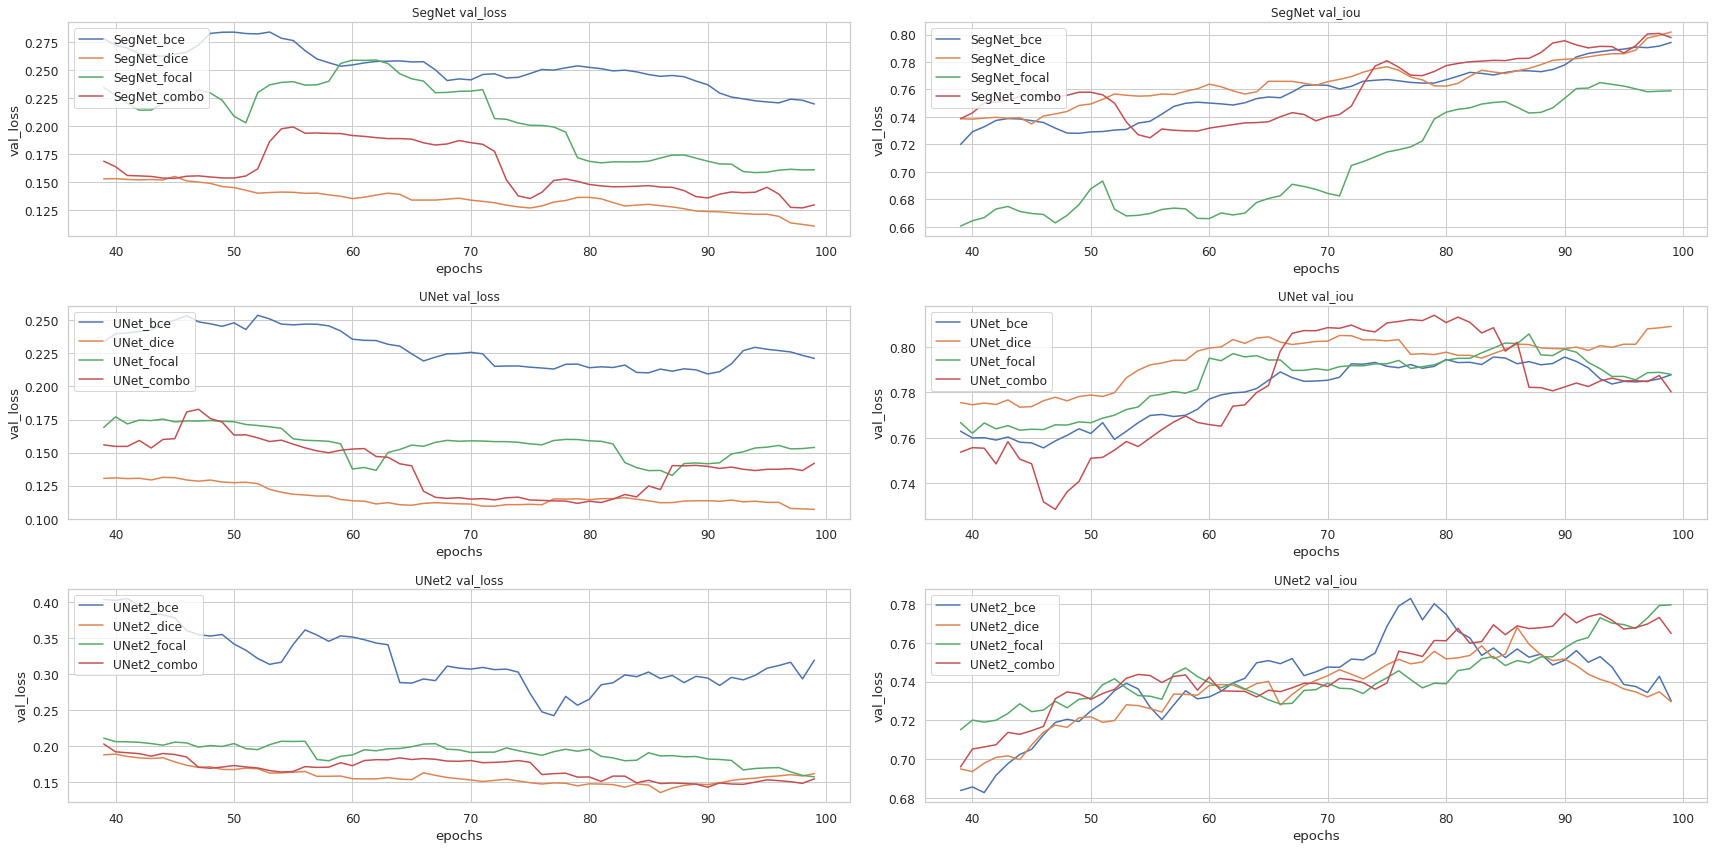

In [48]:
# Функция для сглаживания графиков
def rolling_mean(lst, n):
  return pd.Series(lst).rolling(window=n).mean()

nnets = ['SegNet', 'UNet', 'UNet2']

model_names = [
               'SegNet_bce', 'SegNet_dice', 'SegNet_focal', 'SegNet_combo', 
               'UNet_bce', 'UNet_dice', 'UNet_focal', 'UNet_combo',
               'UNet2_bce', 'UNet2_dice', 'UNet2_focal', 'UNet2_combo'
               ]

model_dicts = [
               dict_Segnet_bce, dict_Segnet_dice, dict_Segnet_focal, dict_Segnet_combo,
               dict_Unet_bce, dict_Unet_dice, dict_Unet_focal, dict_Unet_combo,
               dict_Unet2_bce, dict_Unet2_dice, dict_Unet2_focal, dict_Unet2_combo
               ]

net = 0
start = 0
stop = 4
x = np.arange(20,100)

sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(24, 12))
for i in range(1,6,2):
    
    plt.subplot(3,2,i)
    for name, d_model in zip(model_names[start:stop], model_dicts[start:stop]):
        y = d_model['val_loss'][20:]   
        plt.plot(x, rolling_mean(y,20), label=name)
        plt.legend(loc='upper left')
        plt.xlabel("epochs")
        plt.ylabel("val_loss")
        plt.title(nnets[net] + ' val_loss', fontsize=12)

    plt.subplot(3,2,i+1)
    for name, d_model in zip(model_names[start:stop], model_dicts[start:stop]):
        y = d_model['val_iou'][20:]
        plt.plot(x, rolling_mean(y,20), label=name)
        plt.legend(loc='upper left')
        plt.xlabel("epochs")
        plt.ylabel("val_loss")
        plt.title(nnets[net] + ' val_iou', fontsize=12)

    net += 1
    start += 4
    stop += 4
# plt.suptitle('Losses and metrics of all model during training', fontsize=18)
plt.tight_layout()
plt.show()

В целом по графикам можно судить о том, что продолжение обучение после 80 эпохи не дает ощутимого прироста качества предсказаний или снижения функции потерь. Для достижения лучших результатов нужно менять параметры. Например, шаг градиентного спуска.

In [46]:
# Выведем сводную таблицу по моделям
df_pivot = pd.read_csv(os.path.join(DATA_DIR, 'pivot_table_models.csv'), index_col=0)
df_pivot

SegNet_bce SegNet_dice  ... UNet2_focal UNet2_combo
loss_name    bce_loss   dice_loss  ...  focal_loss  combo_loss
num_params   22361089    22361089  ...    18412033    18412033
epochs            100         100  ...         100         100
train_time        754         757  ...         873         874
batch_size         25          25  ...          10          10
best_epoch         93          93  ...          99          91
best_time         699         702  ...         862         793
iou_val        0.8328      0.8401  ...      0.8467      0.8419
iou_test       0.8506      0.8199  ...      0.8276      0.7943

[9 rows x 12 columns]

Метрика iou была рассчитана после завершения обучения модели (функция обучения возвращает модель с параметрами, выбранными по самой высокой метрике iou на валидации).\
Итоговый результат по метрике среди моделей следующий:
- SegNet:
  - best iou_val: функция потерь combo_loss
  - best iou_test: функция потерь bce_loss
- UNet:
  - best iou_val: функция потерь combo_loss
  - best iou_test: функция потерь bce_loss
- UNet2:
  - best iou_val: функция потерь bce_loss
  - best iou_test: функция потерь bce_loss

- В целом по всем моделям и функциям потерь:
  - best iou_val: UNet c combo_loss. 0.8735
  - best iou_test: UNet c bce_loss. 0.8652

  Отдельно стоит указать, что своего лучшего результата быстрее остальных достигает UNet c dice-loss (на 44 эпохе). Второе место у UNet с bce_loss и focal_loss (72 эпоха).\
  Меньше всего параметров у UNet (15.7 млн), больше всего у SegNet (22.3 млн), однако SegNet учится быстрее, и требует меньше памяти видеокарты.

Для выбора лучшей модели стоит визуально оценить качество предсказаний всех моделей.

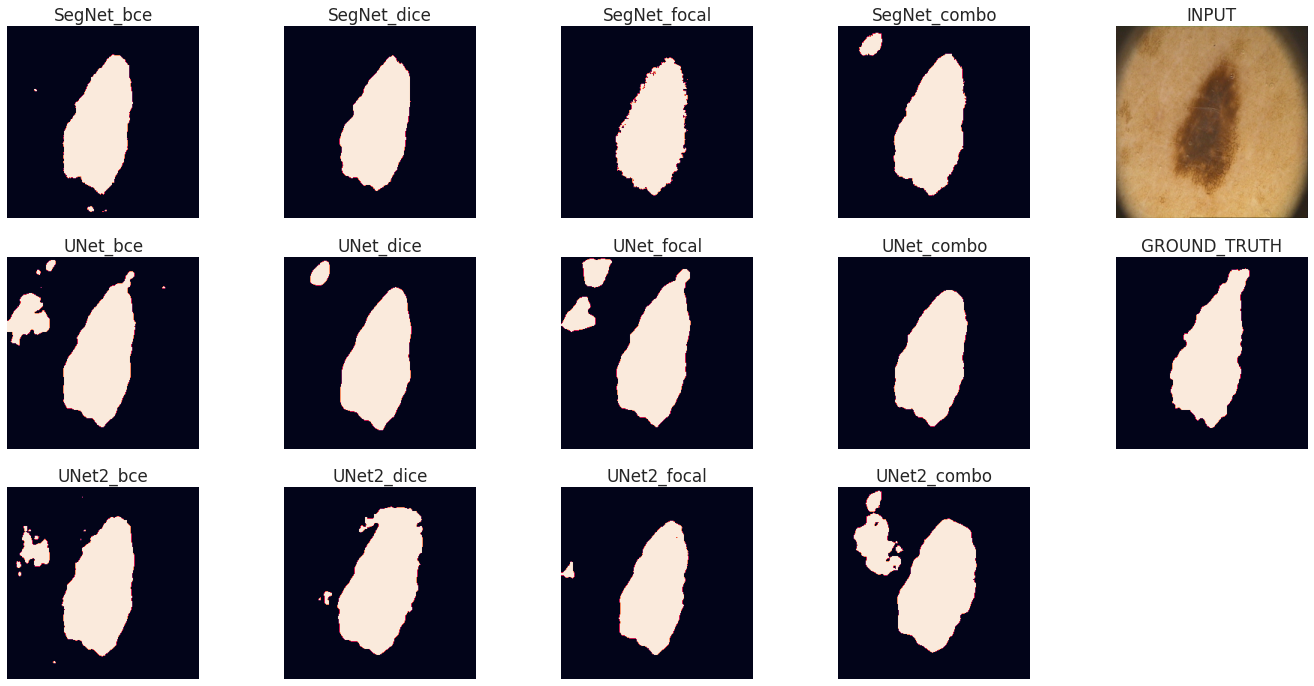

In [57]:
# Посмотрим на предсказания моделей, выполненные по одной и той же картинке.

model_names = [
               'SegNet_bce', 'SegNet_dice', 'SegNet_focal', 'SegNet_combo', 
               'UNet_bce', 'UNet_dice', 'UNet_focal', 'UNet_combo',
               'UNet2_bce', 'UNet2_dice', 'UNet2_focal', 'UNet2_combo'
               ]

with open(os.path.join(DATA_DIR, 'models_predictions.pickle'), 'rb') as f:
  dict_pred = pickle.load(f)

with open(os.path.join(DATA_DIR, 'image_indexes.pickle'), 'rb') as f:
  dict_ind = pickle.load(f)

INPUT = X[dict_ind['ts'][0]]
GROUND_TRUTH = Y[dict_ind['ts'][0]]


plt.figure(figsize=(24, 12))

for i in range(4):
  plt.subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(dict_pred[model_names[i]])
  plt.title(model_names[i])

plt.subplot(3, 5, 5)
plt.axis("off")
plt.imshow(INPUT)
plt.title('INPUT')

for i in range(6,10):
  plt.subplot(3, 5, i)
  plt.axis("off")
  plt.imshow(dict_pred[model_names[i-2]])
  plt.title(model_names[i-2])

plt.subplot(3, 5, 10)
plt.axis("off")
plt.imshow(GROUND_TRUTH)
plt.title('GROUND_TRUTH')

for i in range(11,15):
  plt.subplot(3, 5, i)
  plt.axis("off")
  plt.imshow(dict_pred[model_names[i-3]])
  plt.title(model_names[i-3])

plt.show()

Визуально, истинная маска не идеально описывает исходное изображение. Но если судить по соответсвию предсказаний и истинной маски, то худший результат у UNet2, поскольку сеть выделяет дополнительные области, которых нет в маске. На мой взгляд лучшее предсказание дает SegNet c функциями потерь bce_loss и dice_loss. 

Поскольку по одному изображению все таки не верно делать выводы, я буду опираться на сводную статистику. \
Лучшее качество предсказаний на тестовой выборке показывают:
- UNet c bce_loss. 0.8652
- UNet c dice_loss. 0.8612
- UNet c focal_loss. 0.8584

Однако UNet c dice_loss быстрее достигает своего лучшего качества и более уверена в предсказаниях.
По результатам настоящей работы лучшей моделью признается UNet c dice_loss, обученная с помощью стохастического градиентного спуска по алгоритму Adam с learning rate = 1e-3 на 100 эпохах.

Что еще можно сделать, чтобы повысить качество предсказаний:
- Попробовать различные изменения архитектуры сети, например, UpSample заменить на MaxUnpool с разным ядром. Или поменять боттлнек.
- Попробовать другие алгоритмы градиентного спуска или изменение шага градиентного спуска в процессе обучения.
- Провести эксперименты с различными $\alpha$ и $\beta$ в combo_loss.
- Проверить истинные маски, и исправить их недостатки.